#Business Case and Data Narrative
This data has been used to predict and chart general fitness. This project will focus on finding behavior patterns with FitBit data, and then finding indicators that predict calories burned actual versus predicted. Correlating these activities will be performed by using data mining techniques with Python, on a dataset of 35 users over a 60-day time period in 2020.

This project aims to develop a fitness dashboard with my KPIs using fitbit data.  
Project Description Document is submitted separately. 

# **Domain Understanding**

Project objectives: 
* Visualise how lockdown impacted my health and fitness statistics. 
* Find a model that accurately predicts calories burned (KPI). 
* Create a custom fitness dashboard. 

In [ ]:
#Suppress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from IPython.display import HTML


import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
sns.set(style="darkgrid")
from scipy.stats import norm
from scipy import stats
import pylab 

# **Data Understanding**
**3.1 Overview**

The downloaded data from Fitbit gave me 380 days of data.
Each feature was a separate file which we merged.
https://www.kaggle.com/michess/fitbit-data-and-covid-lockdown

* `Calories` amount of calories burned that day
* `Sedentary minutes`, basically the numbers of minutes you are sitting or lying down that day.
* `Moderately active minutes` & `Very active minutes` on the Fitbit dashboard these are added together and referred to as Active minutes. To earn active minute's you have to go through 10 minutes or more of continuous moderate-to-intense activity.
* `Lightly active minutes` the minutes between sedentary and moderately/very active. 
* `Distance` the total distance travelled in cm.
* `Steps` number of steps taken that day.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Data Amalgamation
Amalgamated data from below website which contains data during lockdown and pre lockdown.
from https://www.kaggle.com/michess/fitbit-data-and-covid-lockdown/data

In [ ]:
data1 = pd.read_csv('/content/gdrive/MyDrive/fitbit_midterm_lockdown.csv')
data2 = pd.read_csv('/content/gdrive/MyDrive/fitbit_midterm_pre_lockdown.csv')
data = pd.concat([data1, data2], ignore_index=True)
data.head(940)
data = data.rename(columns={'dateTime': 'ActivityDate'})
data['ActivityDate'] = pd.to_datetime(data['ActivityDate'], errors='coerce')


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Id                        940 non-null    int64         
 1   ActivityDate              940 non-null    datetime64[ns]
 2   TotalSteps                940 non-null    int64         
 3   TotalDistance             940 non-null    float64       
 4   TrackerDistance           940 non-null    float64       
 5   LoggedActivitiesDistance  940 non-null    float64       
 6   VeryActiveDistance        940 non-null    float64       
 7   ModeratelyActiveDistance  940 non-null    float64       
 8   LightActiveDistance       940 non-null    float64       
 9   SedentaryActiveDistance   940 non-null    float64       
 10  VeryActiveMinutes         940 non-null    int64         
 11  FairlyActiveMinutes       940 non-null    int64         
 12  LightlyActiveMinutes  

The Fitbit data from April 2020(in lockdown). 

In [ ]:
print(data.head(1).round(0))

           Id ActivityDate  ...  SedentaryMinutes  Calories
0  1624580081   2020-04-12  ...              1294      1432

[1 rows x 15 columns]


The Fitbit data from April 2019(pre lockdown)

In [ ]:
print(data.tail(1).round(0))

             Id ActivityDate  ...  SedentaryMinutes  Calories
939  8877689391   2019-05-11  ...              1127      3832

[1 rows x 15 columns]


## **Data Cleaning**

Checking for missing values below. There are missing values for some of the minute features.

In [ ]:
print(data.isnull().sum())

Id                          0
ActivityDate                0
TotalSteps                  0
TotalDistance               0
TrackerDistance             0
LoggedActivitiesDistance    0
VeryActiveDistance          0
ModeratelyActiveDistance    0
LightActiveDistance         0
SedentaryActiveDistance     0
VeryActiveMinutes           0
FairlyActiveMinutes         0
LightlyActiveMinutes        0
SedentaryMinutes            0
Calories                    0
dtype: int64


There are zero values present for `Distance`,`Steps` and the minute features seen below.

In [ ]:
print(data.describe().round(0))

                 Id  TotalSteps  ...  SedentaryMinutes  Calories
count  9.400000e+02       940.0  ...             940.0     940.0
mean   4.855407e+09      7638.0  ...             991.0    2304.0
std    2.424805e+09      5087.0  ...             301.0     718.0
min    1.503960e+09         0.0  ...               0.0       0.0
25%    2.320127e+09      3790.0  ...             730.0    1828.0
50%    4.445115e+09      7406.0  ...            1058.0    2134.0
75%    6.962181e+09     10727.0  ...            1230.0    2793.0
max    8.877689e+09     36019.0  ...            1440.0    4900.0

[8 rows x 14 columns]


As seen above, there are missing values in the minute features. 
Also, the minimum value is zero for several features.
Checking the zero values first below.



In [ ]:
data.loc[data['LightlyActiveMinutes'] == 0]

Id ActivityDate  ...  SedentaryMinutes  Calories
3    6117666160   2020-04-12  ...              1440      1496
5    6775888955   2020-04-12  ...              1440      1841
15   4319703577   2020-04-12  ...              1440      2115
19   6117666160   2020-04-13  ...              1440      1496
28   4020332650   2020-04-13  ...              1440      1981
..          ...          ...  ...               ...       ...
554  8583815059   2019-04-17  ...              1440      2439
650  6290855005   2019-04-23  ...              1407      2664
803  8583815059   2019-05-02  ...              1440      2894
819  8583815059   2019-05-03  ...              1440      3212
827  8583815059   2019-05-04  ...              1440      2516

[84 rows x 15 columns]

 I added each minute feature together and subtracted from 1440. This new feature was called `Missing`. 

In [ ]:
#Checking to see if minutes add up to 1440. 
data['TotalMinutes'] = data['LightlyActiveMinutes'] +data['FairlyActiveMinutes'] +data['SedentaryMinutes'] +data['VeryActiveMinutes']
data['Missing'] = data['TotalMinutes'] - 1440

def complete(x):

    if (x == 1440):
        return 'Yes'
    else:
        return 'No'

data['complete'] = data['TotalMinutes'].apply(complete)

data['complete'].value_counts()

Yes    478
No     462
Name: complete, dtype: int64

There are 41 days where total minutes equal 1,440 minutes. However 16 of these are days were I registered zero active minutes, distance travel and steps taken. So I replaced these days with NaNs. For the days were the total number of minutes total 1,440 minutes, I found the average proportion for each minute feature. Form the this we see that sedentary accounts for on average 91% of the 1,440 minutes each day. 

In [ ]:
#First, address those 16 days. drop all values for those days. 
c = ['Calories', 'LightlyActiveMinutes','FairlyActiveMinutes','SedentaryMinutes','VeryActiveMinutes', 'TotalDistance','TotalSteps']
data[c] = data[c].mask(data['SedentaryMinutes'] == 1440)

#Rerun this to reflect the changing of the 16 days.
data['Total minutes'] = data['LightlyActiveMinutes'] +data['FairlyActiveMinutes'] +data['SedentaryMinutes'] +data['VeryActiveMinutes']
data['Missing'] = data['Total minutes'] - 1440

def complete(x):

    if (x == 1440):
        return 'Yes'
    else:
        return 'No'

data['complete'] = data['Total minutes'].apply(complete)

#Investigating the days where each of the minute features
#seperate these days into a datframe 
total = data['complete'] == 'Yes'
total_1 = data.loc[total]
total_1 = total_1.copy()

total_1['sed_per'] = total_1['SedentaryMinutes'] / 1440

total_1['lig_per'] = total_1['LightlyActiveMinutes'] / 1440

total_1['mod_per'] = total_1['FairlyActiveMinutes'] / 1440

total_1['very_per'] = total_1['VeryActiveMinutes'] / 1440

print(total_1[['sed_per']].mean().round(4))
print(total_1[['lig_per']].mean().round(4)) 
print(total_1[['mod_per']].mean().round(4)) 
print(total_1[['very_per']].mean().round(4)) 

sed_per    0.8302
dtype: float64
lig_per    0.1457
dtype: float64
mod_per    0.0081
dtype: float64
very_per    0.0159
dtype: float64


Using the proportions found I assigned the unaccounted minutes from `Missing` to each of the minute features.  

In [ ]:
data['sed_per'] = (data['Missing'] * -0.9071).round(0)
data['lig_per'] = (data['Missing'] * -0.0585).round(0)
data['mod_per'] = (data['Missing'] * -0.0073).round(0)
data['very_per'] = (data['Missing'] * -0.0271).round(0)

data['per_tot'] = data['sed_per']+ data['lig_per'] + data['mod_per']  +data['very_per'] 
data['diff'] = data['per_tot'] + data['Missing']


#Disperse these minutes to each minute feature
data['LightlyActiveMinutes'] = data['LightlyActiveMinutes'] + data['lig_per'] 
data['FairlyActiveMinutes'] = data['FairlyActiveMinutes'] + data['mod_per']
data['SedentaryMinutes'] = data['SedentaryMinutes']  + data['sed_per']
data['VeryActiveMinutes'] = data['VeryActiveMinutes'] + data['very_per'] 
data['SedentaryMinutes'] = data['SedentaryMinutes'] - data['diff']
data['recheck'] = data['LightlyActiveMinutes'] +data['FairlyActiveMinutes'] +data['SedentaryMinutes'] +data['VeryActiveMinutes']
#dropping 
data=data.drop(['Missing','complete','Total minutes', 'per_tot' , 'sed_per', 'lig_per','mod_per','very_per','diff','recheck'],axis=1) 

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Id                        940 non-null    int64         
 1   ActivityDate              940 non-null    datetime64[ns]
 2   TotalSteps                861 non-null    float64       
 3   TotalDistance             861 non-null    float64       
 4   TrackerDistance           940 non-null    float64       
 5   LoggedActivitiesDistance  940 non-null    float64       
 6   VeryActiveDistance        940 non-null    float64       
 7   ModeratelyActiveDistance  940 non-null    float64       
 8   LightActiveDistance       940 non-null    float64       
 9   SedentaryActiveDistance   940 non-null    float64       
 10  VeryActiveMinutes         861 non-null    float64       
 11  FairlyActiveMinutes       861 non-null    float64       
 12  LightlyActiveMinutes  

Next to replaced the NaNs, I created features for the day of the week and lockdown status. 

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Id                        940 non-null    int64         
 1   ActivityDate              940 non-null    datetime64[ns]
 2   TotalSteps                861 non-null    float64       
 3   TotalDistance             861 non-null    float64       
 4   TrackerDistance           940 non-null    float64       
 5   LoggedActivitiesDistance  940 non-null    float64       
 6   VeryActiveDistance        940 non-null    float64       
 7   ModeratelyActiveDistance  940 non-null    float64       
 8   LightActiveDistance       940 non-null    float64       
 9   SedentaryActiveDistance   940 non-null    float64       
 10  VeryActiveMinutes         861 non-null    float64       
 11  FairlyActiveMinutes       861 non-null    float64       
 12  LightlyActiveMinutes  

In [ ]:
data.head()

Id  TrackerDistance  ...  Week_status_Weekend  cluster
ActivityDate                               ...                              
2020-04-12    1624580081             5.31  ...                    1        1
2020-04-12    3977333714             5.98  ...                    1        6
2020-04-12    2026352035             2.74  ...                    1        1
2020-04-12    6117666160             0.00  ...                    1        1
2020-04-12    3372868164             3.24  ...                    1        1

[5 rows x 22 columns]

In [ ]:

#Create a feature for each day of the week
data['Day of the week'] = data['ActivityDate'].dt.day_name()
data['Day of the week'] = data['Day of the week'].replace('Monday', 'Mon')
data['Day of the week'] = data['Day of the week'].replace('Tuesday', 'Tues')
data['Day of the week'] = data['Day of the week'].replace('Wednesday', 'Wed')
data['Day of the week'] = data['Day of the week'].replace('Thursday', 'Thurs')
data['Day of the week'] = data['Day of the week'].replace('Friday', 'Fri')
data['Day of the week'] = data['Day of the week'].replace("Saturday", "Sat")
data['Day of the week'] = data['Day of the week'].replace("Sunday", "Sun")
#Create a feature for if its the lockdown
def lockdown(x):

    if (x >= pd.to_datetime('2020-03-27')) & (x <=pd.to_datetime('2020-05-30')):
        return 'Yes'
    # elif (x >= pd.to_datetime('2015-10-22')) & (x <=pd.to_datetime('2016-04-30')):
    #     return 'Yes'
    # elif (x >=pd.to_datetime('2015-12-24')):
    #     return 'Yes'
    else:
        return 'No'

data['In lockdown'] = data['ActivityDate'].apply(lockdown)

In [ ]:
data['In lockdown'].unique()

array(['Yes', 'No'], dtype=object)

Missing values for each feature were filled with the average value based for that day of the week and if we were in lockdown or not. 

In [ ]:
#Filling in missing values
data['Calories'] = data.groupby(['In lockdown','Day of the week'])['Calories'].apply(lambda x: x.fillna(x.mean()))
data['LightlyActiveMinutes'] = data.groupby(['In lockdown','Day of the week'])['LightlyActiveMinutes'].apply(lambda x: x.fillna(x.mean()))
data['FairlyActiveMinutes'] = data.groupby(['In lockdown','Day of the week'])['FairlyActiveMinutes'].apply(lambda x: x.fillna(x.mean()))
data['SedentaryMinutes'] = data.groupby(['In lockdown','Day of the week'])['SedentaryMinutes'].apply(lambda x: x.fillna(x.mean()))
data['VeryActiveMinutes'] = data.groupby(['In lockdown','Day of the week'])['VeryActiveMinutes'].apply(lambda x: x.fillna(x.mean()))
data['TotalSteps'] = data.groupby(['In lockdown','Day of the week'])['TotalSteps'].apply(lambda x: x.fillna(x.mean()))
data['TotalDistance'] = data.groupby(['In lockdown','Day of the week'])['TotalDistance'].apply(lambda x: x.fillna(x.mean()))

#delete
del c, total, total_1

# **EDA and Visualization**

The target feature is calories burned, the plot below shows it is pretty close to a normal distribution.

Text(0.5, 1.0, 'Calories Burned Histogram (kcal)')

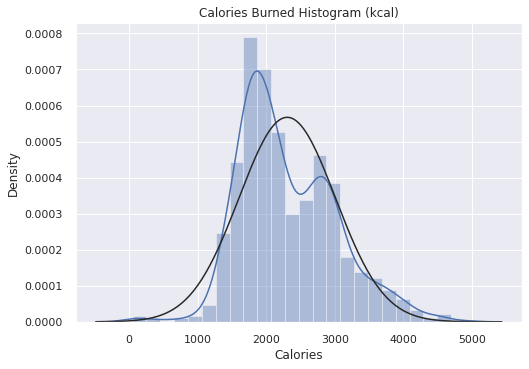

In [ ]:
#Target Calories
#histogram and normal probability plot
sns.distplot(data['Calories'], fit=norm).set_title('Calories Burned Histogram (kcal)')

Average calories burned over the period was 2,500.

In [ ]:
#stats
print(data['Calories'].describe().round(0))

count     940.0
mean     2307.0
std       704.0
min        52.0
25%      1779.0
50%      2134.0
75%      2797.0
max      4900.0
Name: Calories, dtype: float64


The scatterplot below illustrates the target and features relationships. We converted 'Distance' from cm to km to make the plot clearer.
A clear positive linear relationship between calories and steps & distance.
The three active minutes are much more dispersed and positive. The sedentary is dispersed and negative. There is a strong linear relationship between `Distance` & `Steps`. 

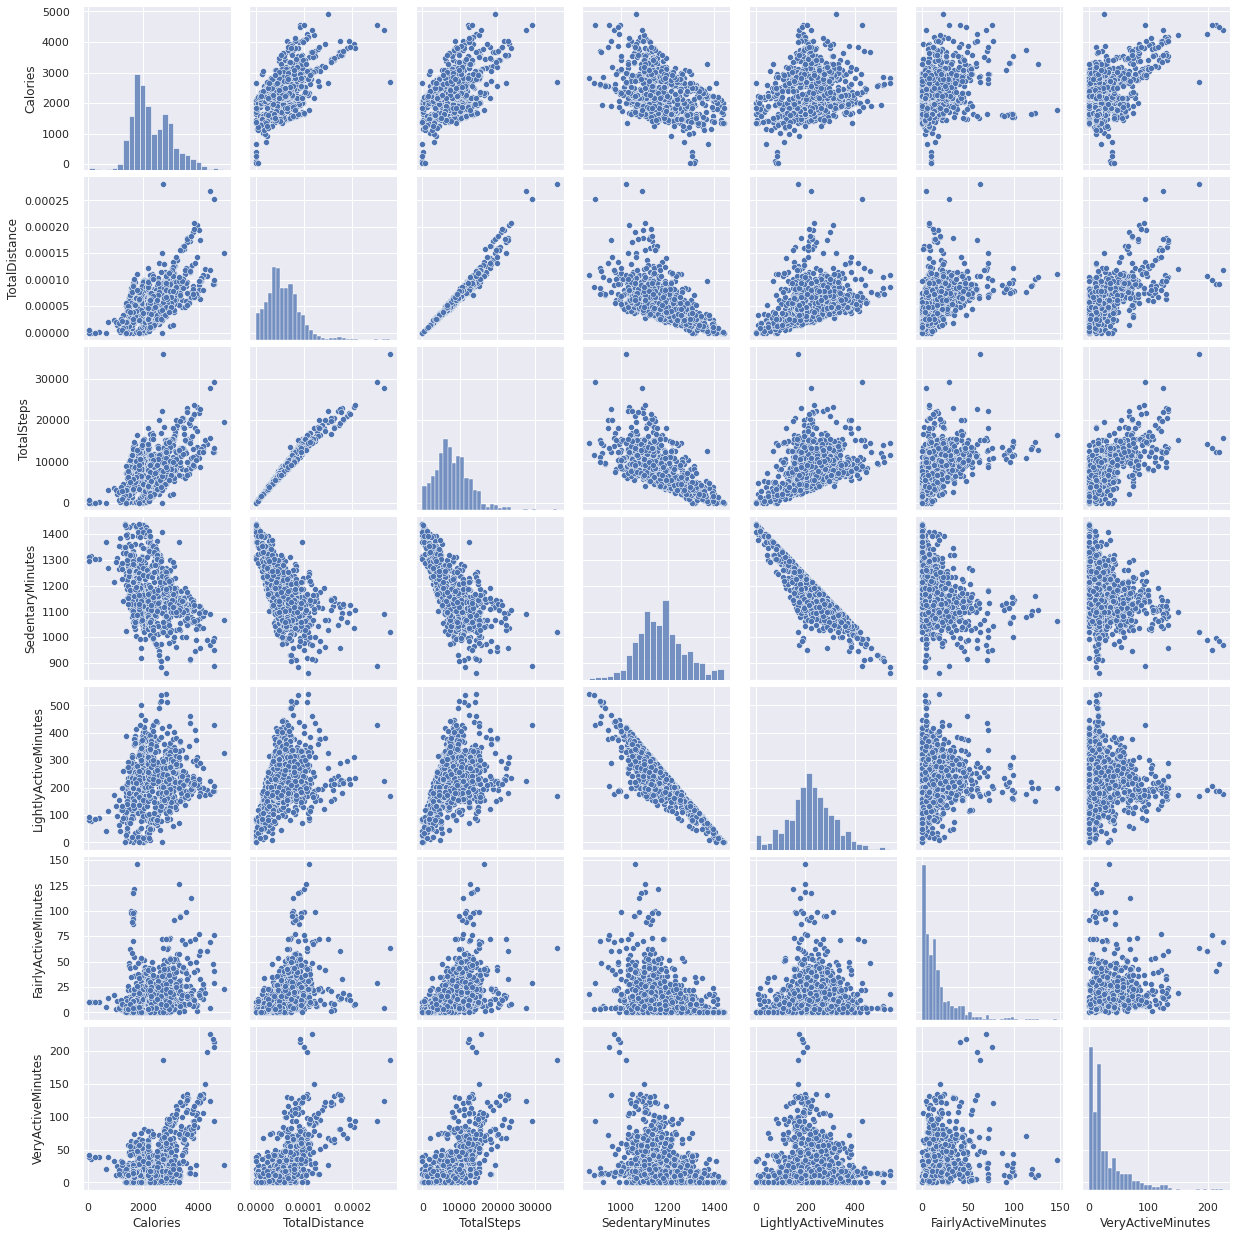

In [ ]:
#Scatter plot
#Changing TotalDistance to km
def dist(x):
    return (x)/100000
data[['TotalDistance']] = data[['TotalDistance']].apply(dist)

sns.set()
cols = ['Calories', 'TotalDistance', 'TotalSteps', 'SedentaryMinutes', 'LightlyActiveMinutes', 'FairlyActiveMinutes', 'VeryActiveMinutes']
sns.pairplot(data[cols])
plt.show()


Looking at the impacts of lockdown on calories burned. 
The bar plot below shows the data during country was in lockdown for **66%**.

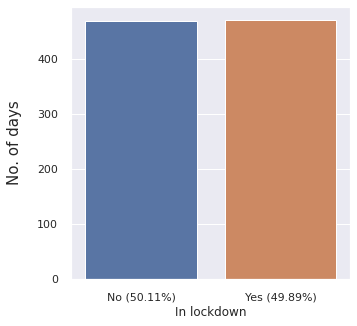

In [ ]:
Yes = data['In lockdown'].value_counts()['Yes']
No = data['In lockdown'].value_counts()['No']
Yes_per = Yes / data.shape[0] * 100
No_per = No / data.shape[0] * 100

plt.figure(figsize=(5, 5))
sns.countplot(data['In lockdown'])
plt.ylabel('No. of days', size=15, labelpad=15)
plt.xticks((0, 1), ['No ({0:.2f}%)'.format(No_per), 'Yes ({0:.2f}%)'.format(Yes_per)])
plt.show()

In [ ]:
#Filter by Lockdown
print(data.groupby(['In lockdown']).mean().round(0))
lock = data.groupby(['In lockdown']).mean().round(0)

order = ["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat","Sun"]

                       Id  TotalSteps  ...  Calories  TotalMinutes
In lockdown                            ...                        
No           5.681474e+09     10001.0  ...    2865.0        1226.0
Yes          4.025818e+09      6271.0  ...    1747.0        1211.0

[2 rows x 15 columns]


The stats show a negative impact across all fitness metrics. 

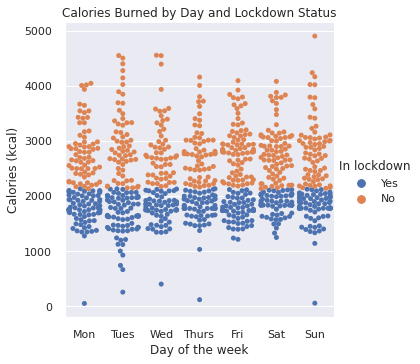

In [ ]:
swarmplot_1 = sns.catplot(x='Day of the week', y="Calories", hue="In lockdown", kind="swarm", data=data, order=order)
ax = plt.gca()
ax.set_title('Calories Burned by Day and Lockdown Status')
ax.set_ylabel('Calories (kcal)')
print(swarmplot_1)

The times when fewer calories burnt nearly all occurred during the lockdown days. While the most calories generally happened on days, not in lockdown.   

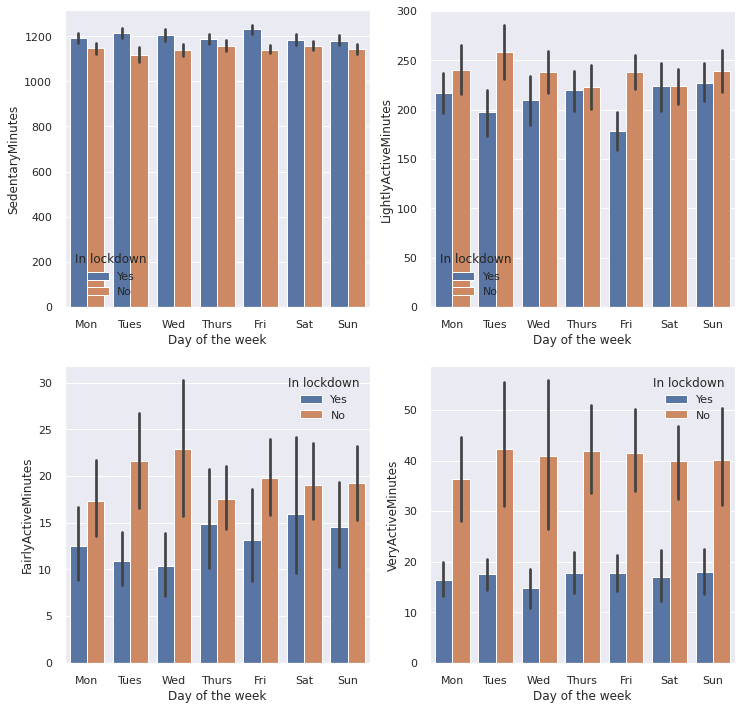

In [ ]:
#bar plots minutes
plt.figure(figsize=[12,12])
plt.subplot(2,2,1)
b1 = sns.barplot(x="Day of the week", y="SedentaryMinutes", hue="In lockdown",data=data, order=order)
plt.subplot(2,2,2)
b2=sns.barplot(x="Day of the week", y="LightlyActiveMinutes", hue="In lockdown",data=data, order=order)
plt.subplot(2,2,3)
b3=sns.barplot(x="Day of the week", y="FairlyActiveMinutes", hue="In lockdown",data=data, order=order)
plt.subplot(2,2,4)
b4 = sns.barplot(x="Day of the week", y="VeryActiveMinutes", hue="In lockdown",data=data, order=order)

Lockdown had the biggest impact on Very Active Minutes feature more than any other feature. 

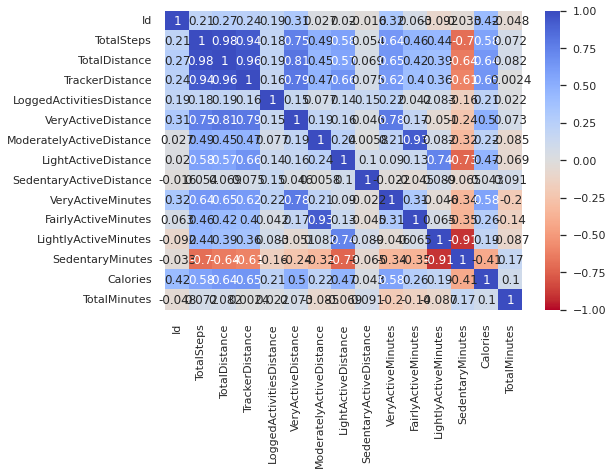

In [ ]:
#Correlation 
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm_r')

Viewing the correlation matrix Calories is strngly coreelated with `Distance` & `Steps`. We saw in the scatterplot that these two are highly correlated. This could cause some issues with our models latter. 

# **Data Preparation, Data Redistribution with second Amalgamation**

* create a new feature for average steps per meter.
* feature for weekday or weekend.
* combined very active and moderately active similar to the Fitbit dashboard.

In [ ]:
#Create a feature for if its the weekend or weekday.
def week_status(x):
    
    if (x == 'Sat'):
        return 'Weekend'
    elif (x == 'Sun'):
        return 'Weekend'
    else:
        return 'Weekday'

data['Week_status'] = data['Day of the week'].apply(week_status)
#on fitbit dashboard very active and moderately active are added together and reported as Active minutes
data['Active minutes'] = data['VeryActiveMinutes'] + data['FairlyActiveMinutes']
#Avg TotalSteps per meter
data['Avg steps per km'] = data['TotalSteps'] / (data['TotalDistance'])

#dropping
data=data.drop(['VeryActiveMinutes', 'FairlyActiveMinutes'],axis=1)  
data=data.drop(['TotalSteps', 'TotalDistance'],axis=1)  

Rechecking the correlations again.

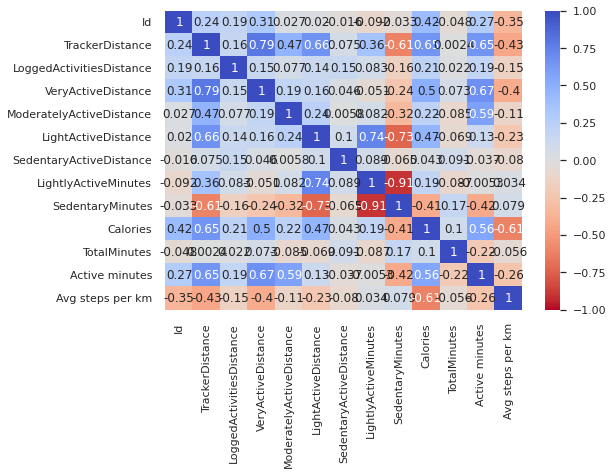

In [ ]:
#Correlation
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm_r')

In [ ]:
#index date
data = data.set_index('ActivityDate')
data = pd.get_dummies(data, drop_first=True)

# a list of the feature names for later
feature_names = ['LightlyActiveMinutes', 'SedentaryMinutes','Active minutes', 'Avg steps per km', 'Day of the week_Mon','Day of the week_Sat', 'Day of the week_Sun', 'Day of the week_Thurs', 'Day of the week_Tues', 'Day of the week_Wed', 'In lockdown_Yes','Week_status_Weekend'] 

In [ ]:
data.info()
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0.0, inplace=True)
data['Avg steps per km'].unique()






<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 940 entries, 2020-04-12 to 2019-05-11
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        940 non-null    int64  
 1   TrackerDistance           940 non-null    float64
 2   LoggedActivitiesDistance  940 non-null    float64
 3   VeryActiveDistance        940 non-null    float64
 4   ModeratelyActiveDistance  940 non-null    float64
 5   LightActiveDistance       940 non-null    float64
 6   SedentaryActiveDistance   940 non-null    float64
 7   LightlyActiveMinutes      940 non-null    float64
 8   SedentaryMinutes          940 non-null    float64
 9   Calories                  940 non-null    float64
 10  TotalMinutes              940 non-null    int64  
 11  Active minutes            940 non-null    float64
 12  Avg steps per km          935 non-null    float64
 13  Day of the week_Mon       940 non-null    uint

array([1.53728815e+08, 1.48093645e+08, 1.61094890e+08, 1.50527730e+08,
       1.46512345e+08, 1.51474922e+08, 1.48832491e+08, 1.54847059e+08,
       1.51320480e+08, 1.53183616e+08, 1.51173821e+08, 1.26159221e+08,
       1.56341465e+08, 1.48909088e+08, 1.43190926e+08, 1.53999994e+08,
       1.49552905e+08, 1.49774797e+08, 1.61064521e+08, 1.52911388e+08,
       1.51122994e+08, 1.51306993e+08, 1.54017221e+08, 1.51196319e+08,
       1.57142862e+08, 1.32016395e+08, 1.48469385e+08, 1.48789066e+08,
       1.47674746e+08, 1.46530918e+08, 1.48793969e+08, 1.61111116e+08,
       1.49530329e+08, 1.50582529e+08, 1.49317970e+08, 1.53834457e+08,
       1.48246265e+08, 1.51271675e+08, 1.55192884e+08, 1.48684206e+08,
       1.51425397e+08, 1.56282057e+08, 1.51179109e+08, 1.35000003e+08,
       1.46666662e+08, 1.51180952e+08, 1.54081630e+08, 1.61223636e+08,
       1.48679869e+08, 1.35050845e+08, 1.50960454e+08, 1.51338585e+08,
       1.55445855e+08, 1.51168476e+08, 1.48290599e+08, 1.46673231e+08,
      

#**PCA**

In [ ]:
X_variables = data.iloc[:,1:20]
X_variables

TrackerDistance  ...  In lockdown_Yes
ActivityDate                   ...                 
2020-04-12           5.310000  ...                1
2020-04-12           5.980000  ...                1
2020-04-12           2.740000  ...                1
2020-04-12           0.000000  ...                1
2020-04-12           3.240000  ...                1
...                       ...  ...              ...
2019-05-11           9.400000  ...                0
2019-05-11           7.840000  ...                0
2019-05-11           7.960000  ...                0
2019-05-11           7.250000  ...                0
2019-05-11          19.559999  ...                0

[940 rows x 19 columns]

In [ ]:
y_variable = data.iloc[:,20]
data.shape

(940, 21)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
transformed_df = sc.fit_transform(X_variables)

In [ ]:
covariance_matrix = np.cov(transformed_df.T)


In [ ]:
covariance_matrix

array([[ 1.00106496e+00,  1.62758445e-01,  7.95184013e-01,
         4.70778219e-01,  6.62069139e-01,  7.46703216e-02,
         3.63380564e-01, -6.08240731e-01,  6.50976395e-01,
         2.41850386e-03,  6.55295514e-01, -2.44508362e-01,
        -4.08779377e-02,  4.73020272e-02,  2.78303390e-02,
        -1.39173345e-02, -1.49510312e-02, -5.97156104e-03,
        -4.94685924e-01],
       [ 1.62758445e-01,  1.00106496e+00,  1.51012917e-01,
         7.66084308e-02,  1.38448798e-01,  1.55161244e-01,
         8.33580033e-02, -1.55193793e-01,  2.11230074e-01,
         2.17124865e-02,  1.87185329e-01, -1.00021235e-01,
        -2.96371590e-02,  4.72528298e-02,  1.92181745e-02,
         5.19234399e-02, -7.31145519e-02, -6.52539407e-02,
        -1.63515481e-01],
       [ 7.95184013e-01,  1.51012917e-01,  1.00106496e+00,
         1.93191397e-01,  1.57837174e-01,  4.61658610e-02,
        -5.09826412e-02, -2.40379937e-01,  4.99780821e-01,
         7.27019898e-02,  6.74502576e-01, -2.68950180e-01,
    

In [ ]:
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

In [ ]:
eigen_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
print('Eigenvalues arranged in descending order:')
for i in eigen_pairs:
    print(i[0])

Eigenvalues arranged in descending order:
4.58548481094258
2.0874495016208834
0.015221791844673848
0.0784035230020395
0.3754779186352589
0.1833043767652638
0.17796277917001416
1.438982682044246
0.6278851130948444
0.7391435933205411
0.8167442597313039
0.9803600974349421
0.9847923781689222
1.2545851339295835
1.1475117969543465
1.1809175953690647
1.1756577684531024
1.1703491713181782
2.7210049211057027e-16


In [ ]:
from sklearn.decomposition import PCA
pca = PCA()

In [ ]:
pca = pca.fit(transformed_df)

In [ ]:
explained_variance = pca.explained_variance_ratio_

In [ ]:
explained_variance

array([2.41084560e-01, 1.09748885e-01, 7.56553605e-02, 6.59605510e-02,
       6.20874368e-02, 6.18108984e-02, 6.15317957e-02, 6.03311074e-02,
       5.17760382e-02, 5.15430085e-02, 4.29408096e-02, 3.88609090e-02,
       3.30114290e-02, 1.97409723e-02, 9.63733537e-03, 9.35649774e-03,
       4.12211132e-03, 8.00294655e-04, 4.17723175e-33])

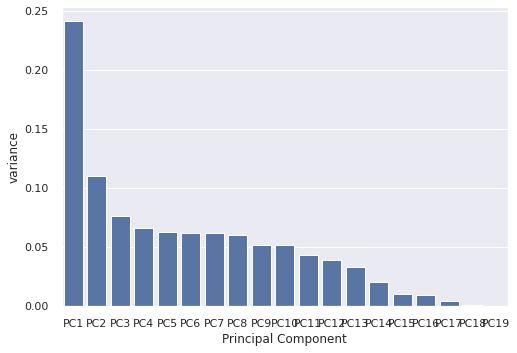

In [ ]:
dataframe = pd.DataFrame({'variance':pca.explained_variance_ratio_,
             'Principal Component':['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19']})
sns.barplot(x='Principal Component',y="variance", 
           data=dataframe, color="b");

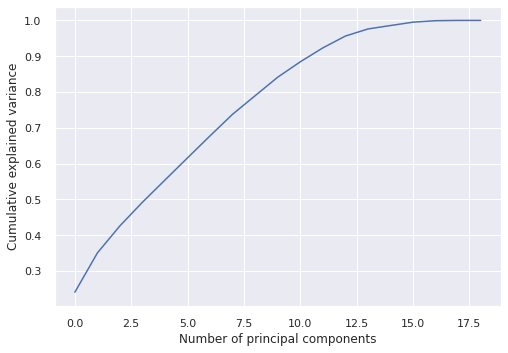

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [ ]:
pca_15 = PCA(n_components =15 )
pca_15 = pca_15.fit(transformed_df)
pca_15d = pca_15.transform(X_variables)

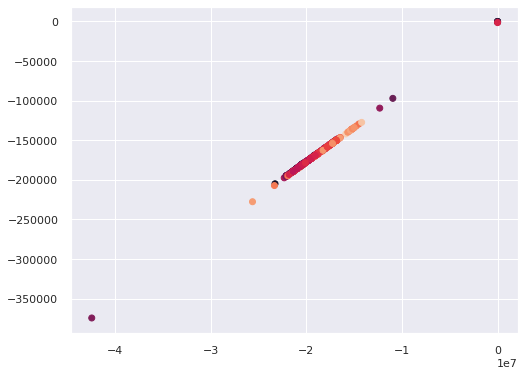

In [ ]:
plt.figure(figsize=(8,6))

plt.scatter(pca_15d[:,0], pca_15d[:,14],c=data['Calories'])
plt.show()

In [ ]:
pca_19 = PCA(n_components =19)
pca_19 = pca_19.fit(transformed_df)
pca_19d = pca_19.transform(X_variables)

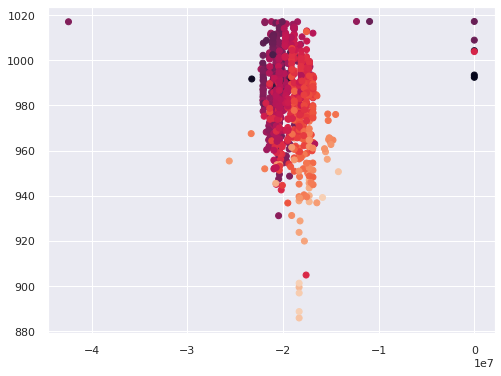

In [ ]:
plt.figure(figsize=(8,6))

plt.scatter(pca_19d[:,0], pca_19d[:,18],c=data['Calories'])
plt.show()

#Feature Importance

In [ ]:
data.info()
y = data['In lockdown_Yes']


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 940 entries, 2020-04-12 to 2019-05-11
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        940 non-null    int64  
 1   TrackerDistance           940 non-null    float64
 2   LoggedActivitiesDistance  940 non-null    float64
 3   VeryActiveDistance        940 non-null    float64
 4   ModeratelyActiveDistance  940 non-null    float64
 5   LightActiveDistance       940 non-null    float64
 6   SedentaryActiveDistance   940 non-null    float64
 7   LightlyActiveMinutes      940 non-null    float64
 8   SedentaryMinutes          940 non-null    float64
 9   Calories                  940 non-null    float64
 10  TotalMinutes              940 non-null    int64  
 11  Active minutes            940 non-null    float64
 12  Avg steps per km          940 non-null    float64
 13  Day of the week_Mon       940 non-null    uint

[2.76034329e-02 3.19336326e-02 2.80995131e-03 1.52149770e-02
 1.05363469e-02 2.18927284e-02 1.71123015e-03 5.62085589e-03
 5.85540420e-03 6.53078456e-02 7.03302553e-03 1.20524515e-02
 4.36820241e-02 5.87878885e-04 8.94300385e-04 4.22928186e-04
 6.38154295e-04 7.22259407e-04 9.15500041e-04 7.43682563e-01
 8.82509802e-04]


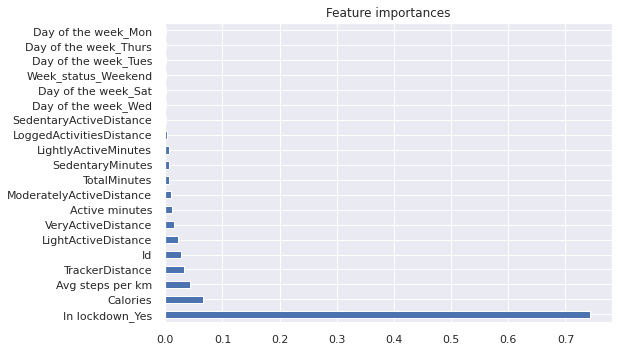

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(criterion='gini') # “gini” for the Gini impurity and “entropy” for the information gain.
model.fit(data, y)
print(model.feature_importances_) # use inbuilt class feature_importances of tree based classifiers
# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=data.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Feature importances")
plt.show()

**Based on the Gini Importance of the features, we perdicted that, In Lockdown_yes, Calories, Active Minutes and Avg steps per km are the most important factors to check the activity.**

#Fractal Clustering on latent variable Active Minutes and VeryActiveDistance.      

In [ ]:
Fractal_df = data

In [ ]:
Fractal_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 940 entries, 2020-04-12 to 2019-05-11
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        940 non-null    int64  
 1   TrackerDistance           940 non-null    float64
 2   LoggedActivitiesDistance  940 non-null    float64
 3   VeryActiveDistance        940 non-null    float64
 4   ModeratelyActiveDistance  940 non-null    float64
 5   LightActiveDistance       940 non-null    float64
 6   SedentaryActiveDistance   940 non-null    float64
 7   LightlyActiveMinutes      940 non-null    float64
 8   SedentaryMinutes          940 non-null    float64
 9   Calories                  940 non-null    float64
 10  TotalMinutes              940 non-null    int64  
 11  Active minutes            940 non-null    float64
 12  Avg steps per km          940 non-null    float64
 13  Day of the week_Mon       940 non-null    uint

##Calories vs Active Minutes

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
import sklearn.metrics as metrics


def plot_cluster(df, max_loop=50):
    """
    Looking at the performance of various number of clusters using K-Means.
    Performance is evaluated by within cluster SSE and silhouette score.
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,[9,11]]
    
    # robust scaling is used so that the centering and scaling statistics are therefore not influenced by a few number of very large marginal outliers as they are based on percentiles
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    sse_within_cluster = {}
    silhouette_score = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10, n_jobs=-1)
        kmeans.fit(X_rb)
        sse_within_cluster[k] = kmeans.inertia_
        silhouette_score[k] = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)

    _ = plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    _ = plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("SSE Within Cluster")
    _ = plt.title("Within Cluster SSE After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    ax2 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)

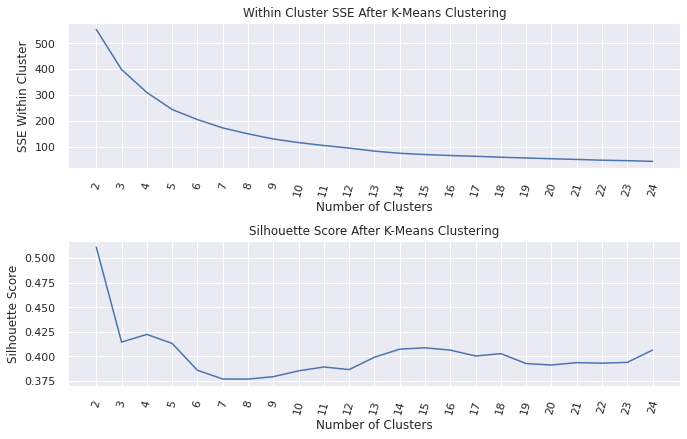

In [ ]:

plot_cluster(Fractal_df, max_loop=25)

First trial With 2 clusters

In [ ]:
def apply_cluster(df, clusters=2):
    """
    Applying K-Means with the optimal number of clusters identified
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,[9,11]]
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init=10, n_jobs=-1)  
    kmeans.fit(X_rb) 
    score = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)
    df['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("clustering performance")
    print("-----------------------------------")
    print("silhouette score: " + str(score.round(2)))
    print("sse withing cluster: " + str(sse_within_cluster.round()))
    
    return df

In [ ]:
first_trial = apply_cluster(Fractal_df, clusters=2)

clustering performance
-----------------------------------
silhouette score: 0.51
sse withing cluster: 553.0


In [ ]:

cluster_perf_df = (
    first_trial
    .groupby('cluster')
    .agg({"Calories":"mean", "Active minutes":"mean"})
    .sort_values('Calories')
    .reset_index()
)

cluster_perf_df


cluster     Calories  Active minutes
0        1  2035.236163       24.357387
1        0  3014.997128       99.034415

In [ ]:
df_sub = Fractal_df.query("cluster == 1").reset_index(drop=True)

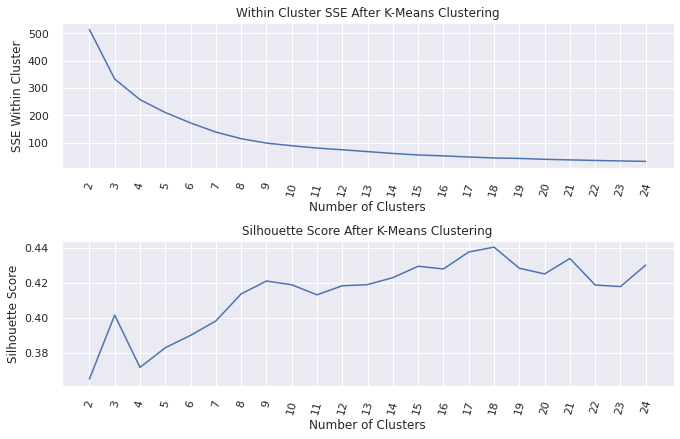

In [ ]:
plot_cluster(df_sub, max_loop=25)

In [ ]:
second_trial= apply_cluster(df_sub, clusters=8)

clustering performance
-----------------------------------
silhouette score: 0.41
sse withing cluster: 114.0


In [ ]:
cluster_perf_df = (
    second_trial
    .groupby('cluster')
    .agg({"Calories":"mean", "Active minutes":"mean"})
    .sort_values('Calories')
    .reset_index()
)

cluster_perf_df

cluster     Calories  Active minutes
0        0   472.777778       45.333333
1        6  1473.186047        6.093023
2        4  1720.430985       29.378680
3        3  1906.312500       68.125000
4        5  2024.390728        7.827815
5        1  2202.030000       41.540000
6        2  2682.920455        9.909091
7        7  2891.740000       36.200000

###Golden Cluster is 5 after second_trial

In [ ]:
best_sub_cluster = second_trial.query("cluster == 5")

In [ ]:
best_sub_cluster

Id  TrackerDistance  ...  Week_status_Weekend  cluster
4    3372868164             3.24  ...                    1        5
6    4558609924             3.39  ...                    1        5
11   1844505072             4.43  ...                    1        5
13   8792009665             1.64  ...                    1        5
14   4445114986             2.20  ...                    1        5
..          ...              ...  ...                  ...      ...
648  1927972279             1.04  ...                    0        5
654  6117666160             5.53  ...                    0        5
661  6290855005             4.75  ...                    0        5
663  4445114986             3.54  ...                    0        5
670  4445114986             2.63  ...                    0        5

[151 rows x 22 columns]





##Calories vs VeryActiveDistance

In [ ]:
def plot_cluster(df, max_loop=50):
    """
    Looking at the performance of various number of clusters using K-Means.
    Performance is evaluated by within cluster SSE and silhouette score.
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,[3,9]]
    
    # robust scaling is used so that the centering and scaling statistics are therefore not influenced by a few number of very large marginal outliers as they are based on percentiles
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    sse_within_cluster = {}
    silhouette_score = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10, n_jobs=-1)
        kmeans.fit(X_rb)
        sse_within_cluster[k] = kmeans.inertia_
        silhouette_score[k] = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)

    _ = plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    _ = plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("SSE Within Cluster")
    _ = plt.title("Within Cluster SSE After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    ax2 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)

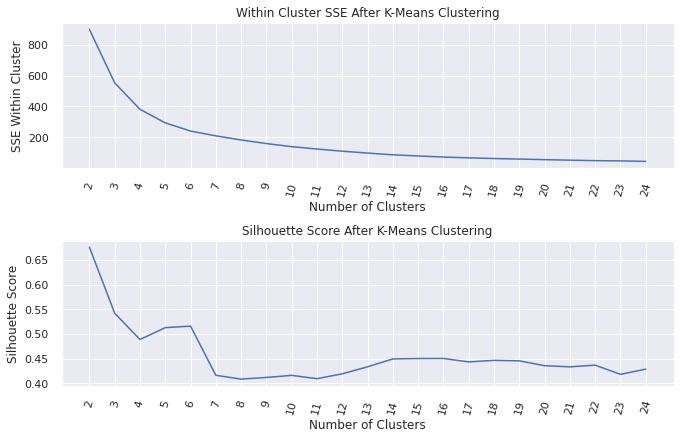

In [ ]:
plot_cluster(Fractal_df, max_loop=25)

In [ ]:
def apply_cluster(df, clusters=7):
    """
    Applying K-Means with the optimal number of clusters identified
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,[3,9]]
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init=10, n_jobs=-1)  
    kmeans.fit(X_rb) 
    score = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)
    df['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("clustering performance")
    print("-----------------------------------")
    print("silhouette score: " + str(score.round(2)))
    print("sse withing cluster: " + str(sse_within_cluster.round()))
    
    return df

In [ ]:
first_trial = apply_cluster(Fractal_df, clusters=7)

clustering performance
-----------------------------------
silhouette score: 0.42
sse withing cluster: 209.0


In [ ]:
cluster_perf_df = (
    first_trial
    .groupby('cluster')
    .agg({"Calories":"mean", "VeryActiveDistance":"mean"})
    .sort_values('Calories')
    .reset_index()
)

cluster_perf_df

cluster     Calories  VeryActiveDistance
0        6  1631.562641            0.096146
1        4  2176.116438            2.645137
2        1  2257.214286            0.264464
3        5  3105.569259            0.624392
4        2  3179.891566            4.926386
5        3  3437.972222           10.924167
6        0  3544.000000           21.790000

Choosing cluster 2, calories burnt is more in lesser distance.

In [ ]:
df_sub = Fractal_df.query("cluster == 2").reset_index(drop=True)

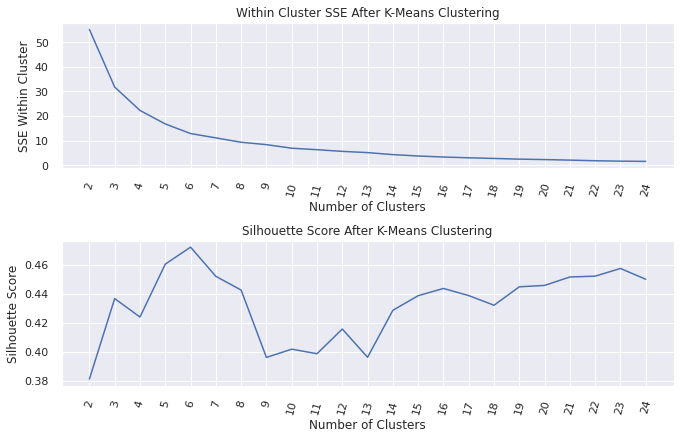

In [ ]:
plot_cluster(df_sub, max_loop=25)

In [ ]:
second_trial= apply_cluster(df_sub, clusters=4)

clustering performance
-----------------------------------
silhouette score: 0.42
sse withing cluster: 22.0


In [ ]:
cluster_perf_df = (
    second_trial
    .groupby('cluster')
    .agg({"Calories":"mean", "VeryActiveDistance":"mean"})
    .sort_values('Calories')
    .reset_index()
)

cluster_perf_df

cluster     Calories  VeryActiveDistance
0        3  2623.826087            5.995652
1        1  2894.448276            4.262414
2        0  3608.176471            3.744118
3        2  4164.642857            5.980714

###Golden cluster is 1 after trials.

In [ ]:
best_sub_cluster = second_trial.query("cluster == 1")

In [ ]:
best_sub_cluster


Id  TrackerDistance  ...  Week_status_Weekend  cluster
6   7007744171             9.48  ...                    0        1
8   7007744171             8.60  ...                    1        1
16  8378563200             8.89  ...                    0        1
19  2022484408            11.40  ...                    0        1
21  2022484408            10.07  ...                    0        1
22  7007744171             9.91  ...                    0        1
26  7007744171             9.50  ...                    0        1
27  7086361926             7.29  ...                    0        1
31  7007744171            10.41  ...                    1        1
32  5577150313             6.22  ...                    1        1
38  2022484408             9.33  ...                    0        1
40  7007744171            10.24  ...                    0        1
43  6962181067            13.24  ...                    0        1
44  4388161847            10.18  ...                    0        1
45  2022484408            10.28  ...                    0        1
47  7086361926             6.82  ...                    0        1
48  7007744171            12.20  ...                    0        1
50  7086361926             7.07  ...                    0        1
55  7007744171             9.06  ...                    1        1
58  8877689391            11.30  ...                    1        1
61  7007744171            13.42  ...                    0        1
67  7007744171             8.72  ...                    0        1
68  4388161847             8.40  ...                    0        1
69  2022484408             8.74  ...                    0        1
70  7007744171             9.71  ...                    0        1
73  7007744171            10.04  ...                    1        1
75  7086361926             8.38  ...                    0        1
79  7086361926             9.11  ...                    0        1
81  2022484408             9.32  ...                    1        1

[29 rows x 22 columns]

#Modelling


Split the data set, 80% train data and 20% test data.
Used multiple regression (MLR) models and Classifiers to find the best fit for the given data.

In [ ]:
#Models
# Import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

# Create training and test sets
# Create arrays for features and target variable

X =  StandardScaler().fit_transform(data.drop(columns ='Calories'))
y = data['Calories'].values

data.head()

X_train, X_test = X[0:int(len(X)*0.8)], X[int(len(X)*0.8):]
y_train, y_test = y[0:int(len(y)*0.8)], y[int(len(y)*0.8):]


#LINEAR MODEL
# Create the regressor: reg
reg = LinearRegression()

# Fit the regressor to the training data
reg.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred_reg = reg.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg.score(X_test, y_test)))
rmse_reg = np.sqrt(mean_squared_error(y_test, y_pred_reg))
print("Root Mean Squared Error: {}".format(rmse_reg))
print("Mean absolute error: {}".format(mean_absolute_error(y_test, y_pred_reg)))


R^2: 0.42536639449223335
Root Mean Squared Error: 380.1997244100481
Mean absolute error: 314.8620763764064


The R squared for the MLR model is 57%. Next, I tried an out of the box Random Forest (RF) model. 

In [ ]:
SEED = 42 #random seed
#RANDOM FOREST Default
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(random_state= SEED)
rfr.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred_rfr = rfr.predict(X_test)

# Compute and print R^2, RMSE and MAE
print("R^2: {}".format(rfr.score(X_test, y_test)))
rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
print("Root Mean Squared Error: {}".format(rmse_rfr))
print("Mean absolute error: {}".format(mean_absolute_error(y_test, y_pred_rfr)))

R^2: 0.8350326218078418
Root Mean Squared Error: 203.71139534541828
Mean absolute error: 138.31981642811823


In [ ]:
#TUNING
from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
grid = {'n_estimators':[100,200,300,500,1000], 'max_depth': [3,5,7], 'max_features': [4,8,12], 'random_state': [SEED] }

test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(X_train, y_train)
    test_scores.append(rfr.score(X_test, y_test))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.8244391287406657 {'random_state': 42, 'n_estimators': 100, 'max_features': 12, 'max_depth': 7}


In [ ]:
#Evaluate performance

#Lastly, and as always, we want to evaluate performance of our best model to check 
#how well or poorly we are doing. 

# Create the random forest model and fit to the training data
rfr_2 = RandomForestRegressor(n_estimators=200, max_depth=7,max_features=12, random_state= SEED)
rfr_2.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred_rfr_2 = rfr_2.predict(X_test)

# Compute and print R^2, RMSE and MAE
print("R^2: {}".format(rfr_2.score(X_test, y_test)))
rmse_rfr_2 = np.sqrt(mean_squared_error(y_test, y_pred_rfr_2))
print("Root Mean Squared Error: {}".format(rmse_rfr_2))
print("Mean absolute error: {}".format(mean_absolute_error(y_test, y_pred_rfr_2)))

R^2: 0.8221231382852623
Root Mean Squared Error: 211.53197130959006
Mean absolute error: 149.661400947435


In [ ]:
data.info()
len(feature_names)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 940 entries, 2020-04-12 to 2019-05-11
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        940 non-null    int64  
 1   TrackerDistance           940 non-null    float64
 2   LoggedActivitiesDistance  940 non-null    float64
 3   VeryActiveDistance        940 non-null    float64
 4   ModeratelyActiveDistance  940 non-null    float64
 5   LightActiveDistance       940 non-null    float64
 6   SedentaryActiveDistance   940 non-null    float64
 7   LightlyActiveMinutes      940 non-null    float64
 8   SedentaryMinutes          940 non-null    float64
 9   Calories                  940 non-null    float64
 10  TotalMinutes              940 non-null    int64  
 11  Active minutes            940 non-null    float64
 12  Avg steps per km          940 non-null    float64
 13  Day of the week_Mon       940 non-null    uint

12

???Our tuned model performs worse than the out of the box one. Below we can see the feature importance. It looks like the day of the week feature isn't that important and may want to drop it. 

[0.02296682 0.04166472 0.00090902 0.01645013 0.00655667 0.00765197
 0.00124189 0.01207735 0.02129425 0.03818779 0.08502828 0.12342344]
[11 10  1  9  0  8  3  7  5  4  6  2]
range(0, 12)


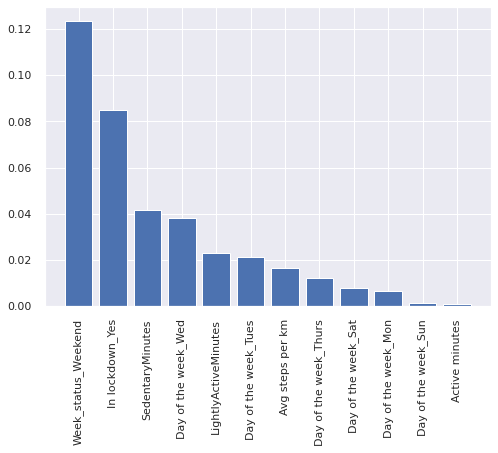

In [ ]:
#Random forest feature importances
# Get feature importances from our random forest model
importances = rfr_2.feature_importances_
importances = importances[:-9]
print(importances)

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
print(sorted_index)
x = range(len(importances))

print(x)

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

Next working with gradient boosting model

In [ ]:
#A gradient boosting model
#GRADIENT BOOSTING REGRESSOR DEFAULT
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model 
gbr = GradientBoostingRegressor(random_state= SEED)
gbr.fit(X_train, y_train)
# Predict on the test data: y_pred
y_pred_gbr = gbr.predict(X_test)
# Compute and print R^2, RMSE and MAE
print("R^2: {}".format(gbr.score(X_test, y_test)))
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
print("Root Mean Squared Error: {}".format(rmse_gbr))
print("Mean absolute error: {}".format(mean_absolute_error(y_test, y_pred_gbr)))

R^2: 0.8246399162029929
Root Mean Squared Error: 210.0301582385774
Mean absolute error: 151.11095882894165


Performs slightly better than MLR. I will tune it to see if I can increase performance. 

In [ ]:
#TUNING GRADIENT MODEL
from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
grid = {'n_estimators':[100,200,300,500,1000], 'learning_rate': [0.01,0.05,0.1], 'max_features': [4,8,12], 'max_depth':[3,5,7], 'random_state': [SEED] }

test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    gbr.set_params(**g)  # ** is "unpacking" the dictionary
    gbr.fit(X_train, y_train)
    test_scores.append(gbr.score(X_test, y_test))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.8848730971669092 {'random_state': 42, 'n_estimators': 1000, 'max_features': 12, 'max_depth': 5, 'learning_rate': 0.05}


In [ ]:
# Create GB model 
gbr_2 = GradientBoostingRegressor(n_estimators = 1000, learning_rate = 0.01, max_features = 8, max_depth = 5, random_state= SEED)
gbr_2.fit(X_train, y_train)
# Predict on the test data: y_pred
y_pred_gbr_2 = gbr_2.predict(X_test)
# Compute and print R^2, RMSE and MAE
print("R^2: {}".format(gbr_2.score(X_test, y_test)))
rmse_gbr_2 = np.sqrt(mean_squared_error(y_test, y_pred_gbr_2))
print("Root Mean Squared Error: {}".format(rmse_gbr_2))
print("Mean absolute error: {}".format(mean_absolute_error(y_test, y_pred_gbr_2)))

R^2: 0.8696302594748683
Root Mean Squared Error: 181.0942612233739
Mean absolute error: 125.71696297541332


The perfromance is increase over the out of the box model and its better than MLR but the tuned RF. An interesting finding from this model is that days of the week feature is important in this model. 

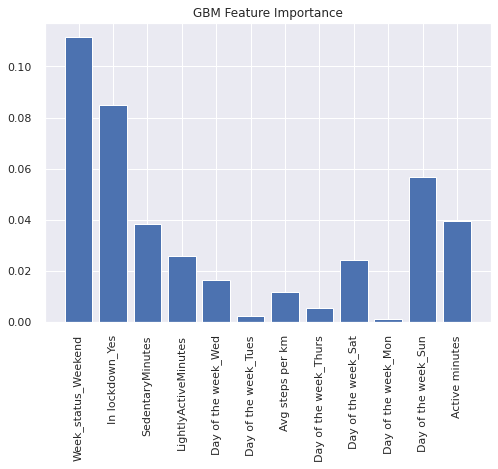

In [ ]:
#GRADIENT BOOSTINGfeature importances
features = data[feature_names]

# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr_2.feature_importances_
feature_importances = feature_importances[:-9]
# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x = range(len(feature_importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, feature_importances[::-1], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.title('GBM Feature Importance')
plt.show()

Plotting the predicted calories over the actual calories in the test data below. It's close but could be better. 

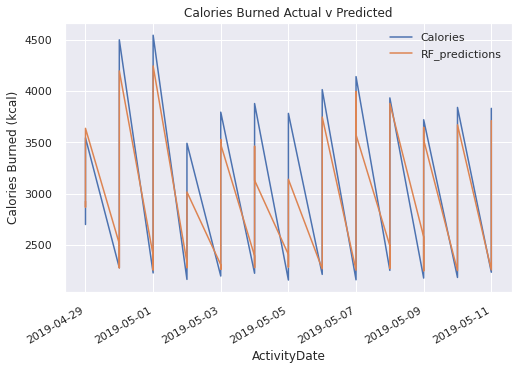

In [ ]:
#Plotting predictions against actual values
Y = data['Calories']
y_index_train, y_index_test = Y[0:int(len(Y)*0.8)], Y[int(len(Y)*0.8):]
perdict = pd.DataFrame(y_pred_rfr_2,  columns=['RF_predictions'],    index=y_index_test.index)

results  = pd.concat([y_index_test, perdict], axis=1)

results.plot(y=['Calories','RF_predictions'])
plt.title('Calories Burned Actual v Predicted')
plt.ylabel('Calories Burned (kcal)')
plt.show()

##Muller Regressor loop with change in data distribution
## R2 score with Change in data distribution








In [ ]:

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.metrics import r2_score
def muellerregresssorloop(data,feat):


  kernel = DotProduct() + WhiteKernel()
  names = ["GradientBoostingRegressor","RandomForestRegressor","LinearRegression","SVR","DecisionTreeRegressor","AdaBoostRegressor","GaussianProcessRegressor"]
  regressors = [GradientBoostingRegressor(n_estimators = 1000, learning_rate = 0.01, max_features = feat, max_depth = 5, random_state= 42), RandomForestRegressor(n_estimators=200, max_depth=7,max_features=feat, random_state= 42), LinearRegression(), SVR(kernel='rbf', gamma='auto'), DecisionTreeRegressor(random_state = 0), AdaBoostRegressor(random_state=0, n_estimators=100), GaussianProcessRegressor(kernel=kernel,random_state=0)]
  #regressors = [GradientBoostingRegressor(n_estimators = 1000, learning_rate = 0.01, max_features = 8, max_depth = 5, random_state= 42), RandomForestRegressor(n_estimators=200, max_depth=7,max_features=12, random_state= 42), LinearRegression(), SVR(kernel='rbf', gamma='auto'), DecisionTreeRegressor(random_state = 0), AdaBoostRegressor(random_state=0, n_estimators=100), GaussianProcessRegressor(kernel=kernel,random_state=0)]

  X =  StandardScaler().fit_transform(data.drop(columns ='Calories'))
  y = data['Calories'].values

  X_train, X_test, y_train, y_test = \
      train_test_split(X, y, test_size=.2)

  # TODO (Apply): All cross-validation

  max_score = 0.0
  max_class = ''
  # iterate over regressors
  for name, clf in zip(names, regressors):
      clf.fit(X_train, y_train)
      score = 100.0 * clf.score(X_test, y_test)
      pred = clf.predict(X_train)
      r2 = r2_score(y_train, pred)
      print('R2 SCORE = %.2f,' %(r2))
      print('regressors = %s, Score (test, accuracy) = %.2f,' %(name, score))
      
      if score > max_score:
          clf_best = clf
          max_score = score
          max_class = name

  print(80*'-' )
  print('Best --> regressors = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
  #plot the output of the various algorithms

### Change in data distribution for regressors

In [ ]:
df_ml = data[['Calories','Avg steps per km','VeryActiveDistance','TotalMinutes','In lockdown_Yes']].copy()
muellerregresssorloop(df_ml,4);

df_ml = data[['Calories','Avg steps per km','VeryActiveDistance','TotalMinutes','In lockdown_Yes']].copy()
muellerregresssorloop(df_ml,4);
 
df_ml = data[['TrackerDistance','LoggedActivitiesDistance','VeryActiveDistance','ModeratelyActiveDistance','LightActiveDistance','LightlyActiveMinutes','SedentaryMinutes','Calories','TotalMinutes','Active minutes','Avg steps per km','In lockdown_Yes']].copy()
muellerregresssorloop(df_ml,11);
 
df_ml = data[['TrackerDistance','LoggedActivitiesDistance','VeryActiveDistance','SedentaryMinutes','Calories','TotalMinutes','Active minutes','Avg steps per km','In lockdown_Yes']].copy()
muellerregresssorloop(df_ml,8);

muellerregresssorloop(data,20)



R2 SCORE = 0.97,
regressors = GradientBoostingRegressor, Score (test, accuracy) = 82.98,
R2 SCORE = 0.93,
regressors = RandomForestRegressor, Score (test, accuracy) = 83.14,
R2 SCORE = 0.71,
regressors = LinearRegression, Score (test, accuracy) = 60.48,
R2 SCORE = 0.16,
regressors = SVR, Score (test, accuracy) = 12.88,
R2 SCORE = 1.00,
regressors = DecisionTreeRegressor, Score (test, accuracy) = 62.01,
R2 SCORE = 0.79,
regressors = AdaBoostRegressor, Score (test, accuracy) = 74.78,
R2 SCORE = 0.02,
regressors = GaussianProcessRegressor, Score (test, accuracy) = 0.81,
--------------------------------------------------------------------------------
Best --> regressors = RandomForestRegressor, Score (test, accuracy) = 83.14
R2 SCORE = 0.96,
regressors = GradientBoostingRegressor, Score (test, accuracy) = 89.01,
R2 SCORE = 0.92,
regressors = RandomForestRegressor, Score (test, accuracy) = 88.57,
R2 SCORE = 0.69,
regressors = LinearRegression, Score (test, accuracy) = 74.49,
R2 SCORE = 0.16

In [ ]:
# define the keras model
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
# X_train, X_test = X[0:int(len(X)*0.8)], X[int(len(X)*0.8):]
# y_train, y_test = y[0:int(len(y)*0.8)], y[int(len(y)*0.8):]
model.add(Dense(12, input_dim=21, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X

array([[-1.33311609, -0.0423413 , -0.17459128, ...,  1.00212993,
         1.56308139,  1.07171539],
       [-0.36231405,  0.12922497, -0.17459128, ...,  1.00212993,
         1.56308139,  0.07031135],
       [-1.16733543, -0.70043867, -0.17459128, ...,  1.00212993,
         1.56308139,  1.07171539],
       ...,
       [-0.06291922,  0.63624164, -0.17459128, ..., -0.9978746 ,
         1.56308139,  0.57101337],
       [ 1.45373779,  0.45443262,  3.2021995 , ..., -0.9978746 ,
         1.56308139,  0.57101337],
       [ 1.65968911,  3.60664218, -0.17459128, ..., -0.9978746 ,
         1.56308139, -0.43039067]])

In [ ]:
# fit the keras model on the dataset

#X.reshape(-1,940*20)
#print(y.shape)
model.fit(X, y, epochs=10, batch_size=10)

Epoch 1/10
94/94 [==============================] - 1s 1ms/step - loss: -2199.6294 - accuracy: 0.0000e+00
Epoch 2/10
94/94 [==============================] - 0s 1ms/step - loss: -11055.3760 - accuracy: 0.0000e+00
Epoch 3/10
94/94 [==============================] - 0s 1ms/step - loss: -31803.4258 - accuracy: 0.0000e+00
Epoch 4/10
94/94 [==============================] - 0s 2ms/step - loss: -77387.4062 - accuracy: 0.0000e+00
Epoch 5/10
94/94 [==============================] - 0s 1ms/step - loss: -161181.0312 - accuracy: 0.0000e+00
Epoch 6/10
94/94 [==============================] - 0s 1ms/step - loss: -295137.5312 - accuracy: 0.0000e+00
Epoch 7/10
94/94 [==============================] - 0s 1ms/step - loss: -488748.4375 - accuracy: 0.0000e+00
Epoch 8/10
94/94 [==============================] - 0s 1ms/step - loss: -750728.3750 - accuracy: 0.0000e+00
Epoch 9/10
94/94 [==============================] - 0s 1ms/step - loss: -1094003.2500 - accuracy: 0.0000e+00
Epoch 10/10
94/94 [=============

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 940 entries, 2020-04-12 to 2019-05-11
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        940 non-null    int64  
 1   TrackerDistance           940 non-null    float64
 2   LoggedActivitiesDistance  940 non-null    float64
 3   VeryActiveDistance        940 non-null    float64
 4   ModeratelyActiveDistance  940 non-null    float64
 5   LightActiveDistance       940 non-null    float64
 6   SedentaryActiveDistance   940 non-null    float64
 7   LightlyActiveMinutes      940 non-null    float64
 8   SedentaryMinutes          940 non-null    float64
 9   Calories                  940 non-null    float64
 10  TotalMinutes              940 non-null    int64  
 11  Active minutes            940 non-null    float64
 12  Avg steps per km          940 non-null    float64
 13  Day of the week_Mon       940 non-null    uint

##Muller Classifier loop with change in data distribution 
##   Confusion Matrix for each classifier with change in data distribution
###   F1 Score with change in data distribution









In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import f1_score
from yellowbrick.classifier import ConfusionMatrix


In [ ]:


def featureTransformation(data):


  names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", #"Gaussian Process",
          "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
          "Naive Bayes", "QDA"]

  classifiers = [
      KNeighborsClassifier(2),
      SVC(kernel="linear", C=0.025),
      SVC(gamma=2, C=1),
  #     GaussianProcessClassifier(1.0 * RBF(1.0)),
      DecisionTreeClassifier(max_depth=5),
      RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
      MLPClassifier(alpha=1, max_iter=1000),
      AdaBoostClassifier(),
      GaussianNB(),
      QuadraticDiscriminantAnalysis()]

  # X, y = X_data_reshape, y_data

  # X = StandardScaler().fit_transform(X)
  # X_train, X_test, y_train, y_test = \
  #     train_test_split(X, y, test_size=.2)
  X =  StandardScaler().fit_transform(data.drop(columns ='In lockdown_Yes'))
  y = data['In lockdown_Yes'].values

  X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.2)



  # TODO (Apply): All cross-validation

  max_score = 0.0
  max_class = ''
  # iterate over classifiers
  for name, clf in zip(names, classifiers):
      clf.fit(X_train, y_train)
      score = 100.0 * clf.score(X_test, y_test)
      pred = clf.predict(X_train)
      # F1 Score matrix
      f1 = f1_score(y_train, pred, average='macro')
      print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score))
      print('F1 SCORE = %.2f,' %(f1))
      fig, ax = plt.subplots()
      #Confusion matrix
      cm = ConfusionMatrix(clf, classes=[0, 1], ax=ax)
      cm.fit(X_train, y_train)
      cm.score(X_test, y_test)
      cm.poof()


      if score > max_score:
          clf_best = clf
          max_score = score
          max_class = name

  print(80*'-' )
  print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
  print(80*'-' )
  #plot the output of the various algorithms

### Change in data distribution for Classifiers

Classifier = Nearest Neighbors, Score (test, accuracy) = 93.62,
F1 SCORE = 0.98,


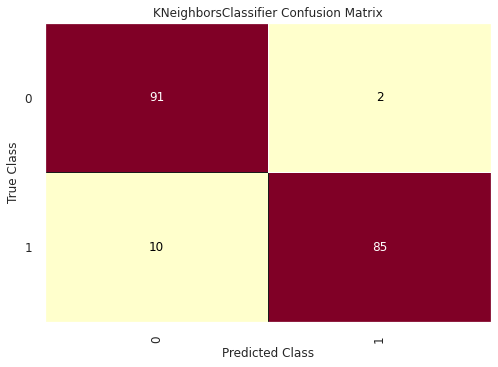

Classifier = Linear SVM, Score (test, accuracy) = 93.09,
F1 SCORE = 0.93,


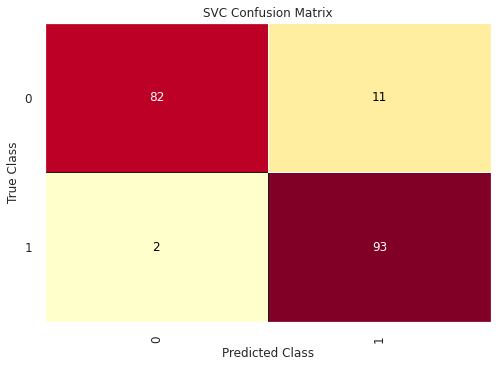

Classifier = RBF SVM, Score (test, accuracy) = 97.34,
F1 SCORE = 0.99,


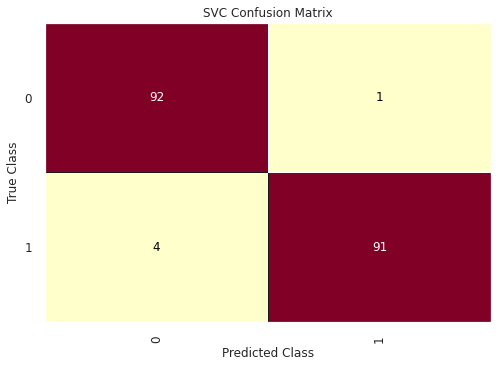

Classifier = Decision Tree, Score (test, accuracy) = 100.00,
F1 SCORE = 1.00,


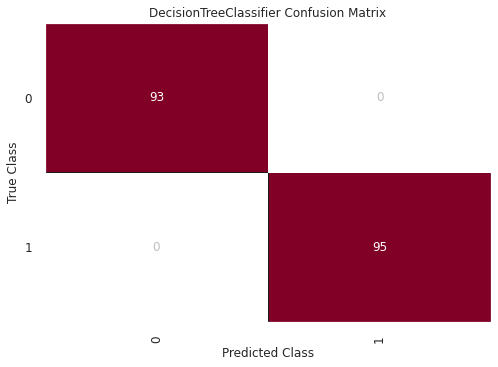

Classifier = Random Forest, Score (test, accuracy) = 100.00,
F1 SCORE = 1.00,


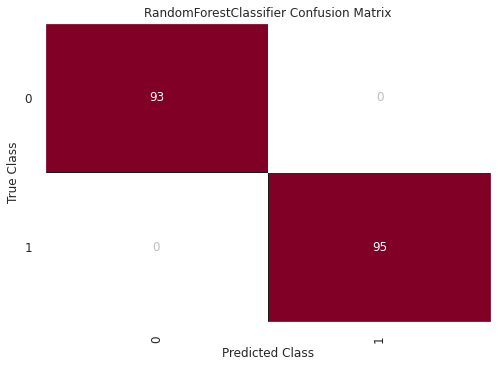

Classifier = Neural Net, Score (test, accuracy) = 98.40,
F1 SCORE = 0.99,


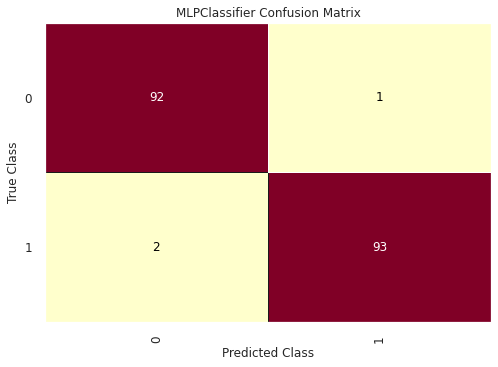

Classifier = AdaBoost, Score (test, accuracy) = 100.00,
F1 SCORE = 1.00,


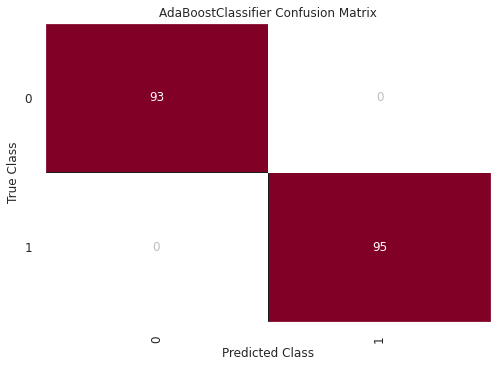

Classifier = Naive Bayes, Score (test, accuracy) = 89.36,
F1 SCORE = 0.91,


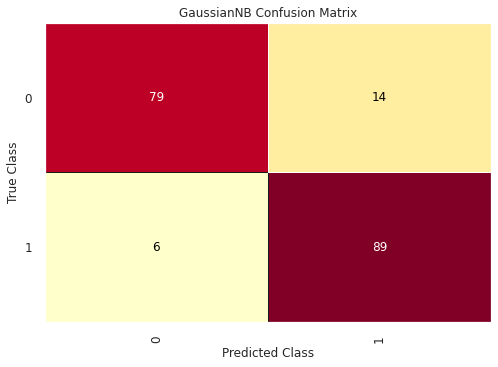

Classifier = QDA, Score (test, accuracy) = 94.15,
F1 SCORE = 0.96,


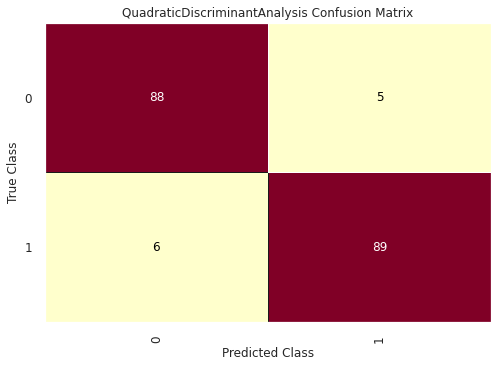

--------------------------------------------------------------------------------
Best --> Classifier = Decision Tree, Score (test, accuracy) = 100.00
--------------------------------------------------------------------------------
Classifier = Nearest Neighbors, Score (test, accuracy) = 96.28,
F1 SCORE = 0.98,


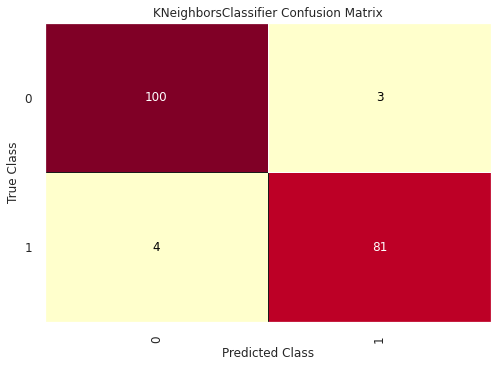

Classifier = Linear SVM, Score (test, accuracy) = 90.43,
F1 SCORE = 0.94,


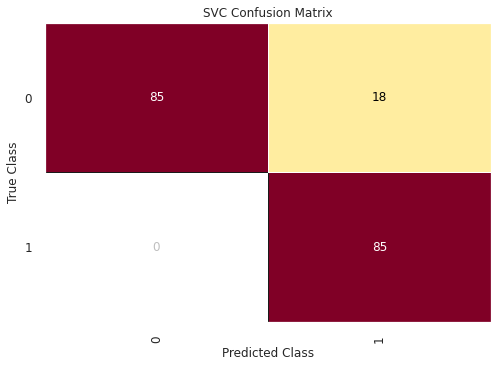

Classifier = RBF SVM, Score (test, accuracy) = 96.81,
F1 SCORE = 0.99,


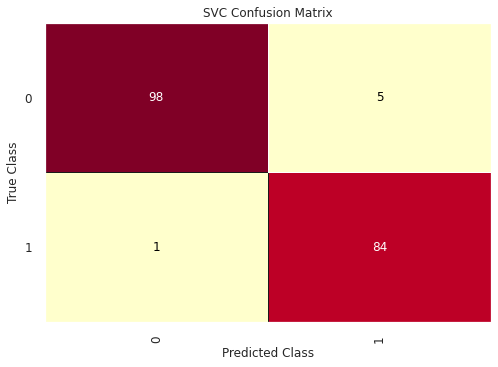

Classifier = Decision Tree, Score (test, accuracy) = 100.00,
F1 SCORE = 1.00,


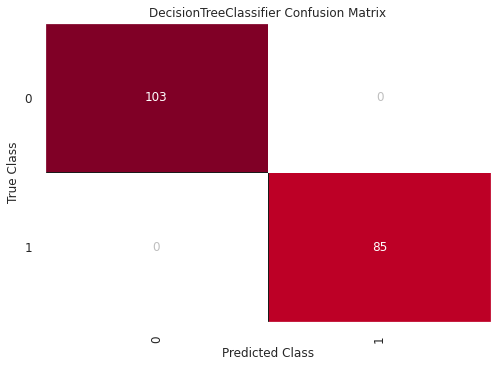

Classifier = Random Forest, Score (test, accuracy) = 100.00,
F1 SCORE = 1.00,


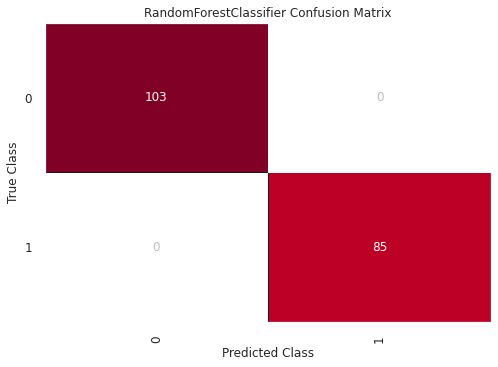

Classifier = Neural Net, Score (test, accuracy) = 97.87,
F1 SCORE = 0.99,


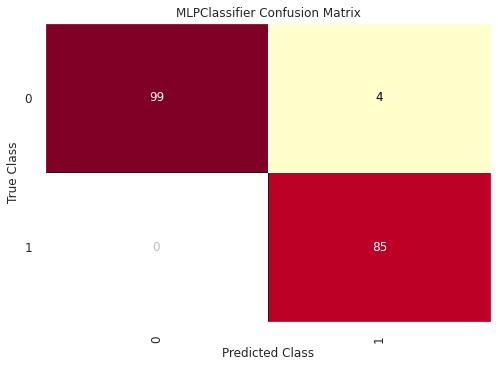

Classifier = AdaBoost, Score (test, accuracy) = 100.00,
F1 SCORE = 1.00,


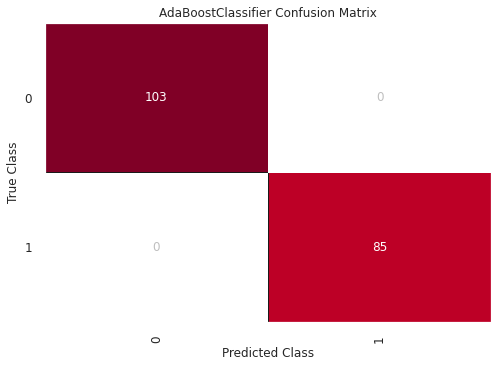

Classifier = Naive Bayes, Score (test, accuracy) = 89.36,
F1 SCORE = 0.92,


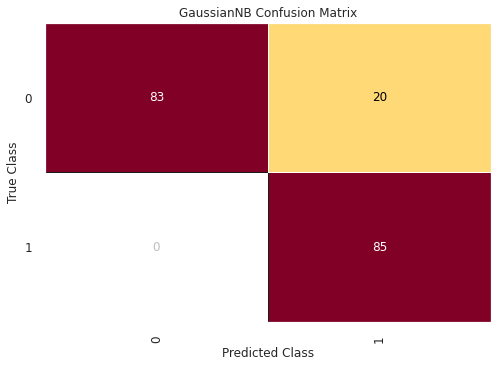

Classifier = QDA, Score (test, accuracy) = 95.74,
F1 SCORE = 0.96,


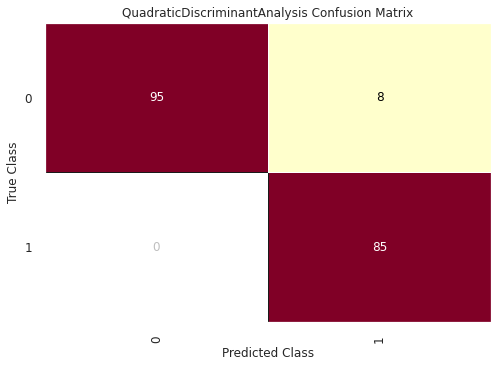

--------------------------------------------------------------------------------
Best --> Classifier = Decision Tree, Score (test, accuracy) = 100.00
--------------------------------------------------------------------------------
Classifier = Nearest Neighbors, Score (test, accuracy) = 91.49,
F1 SCORE = 0.98,


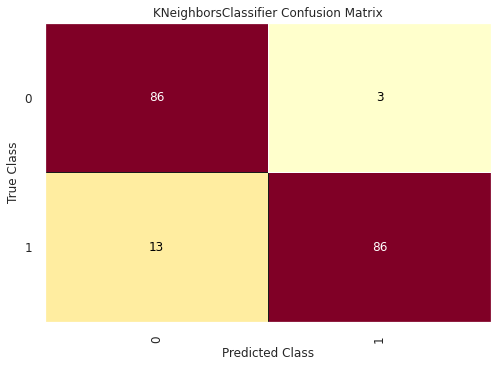

Classifier = Linear SVM, Score (test, accuracy) = 94.68,
F1 SCORE = 0.94,


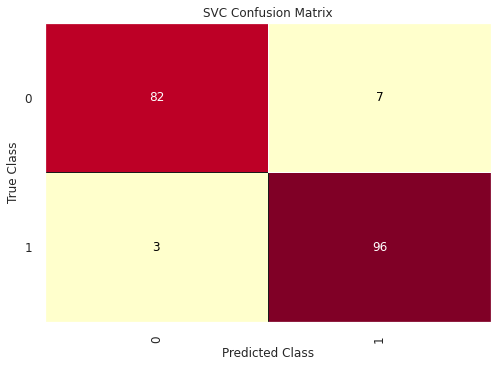

Classifier = RBF SVM, Score (test, accuracy) = 92.55,
F1 SCORE = 1.00,


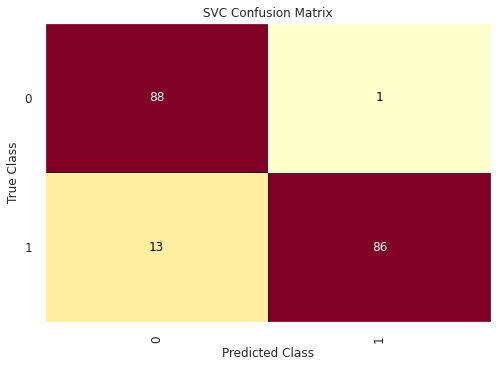

Classifier = Decision Tree, Score (test, accuracy) = 99.47,
F1 SCORE = 1.00,


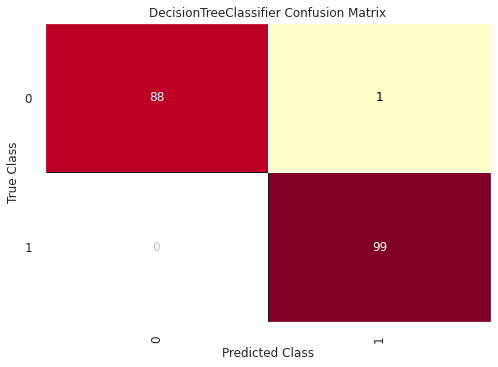

Classifier = Random Forest, Score (test, accuracy) = 97.34,
F1 SCORE = 0.99,


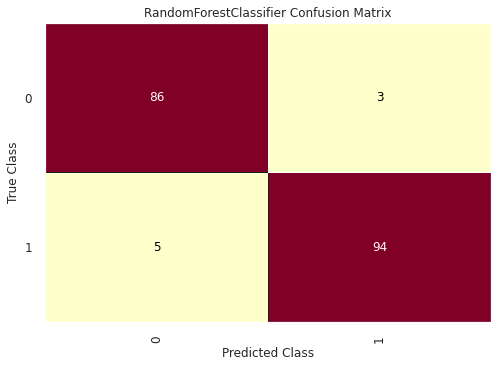

Classifier = Neural Net, Score (test, accuracy) = 98.40,
F1 SCORE = 0.99,


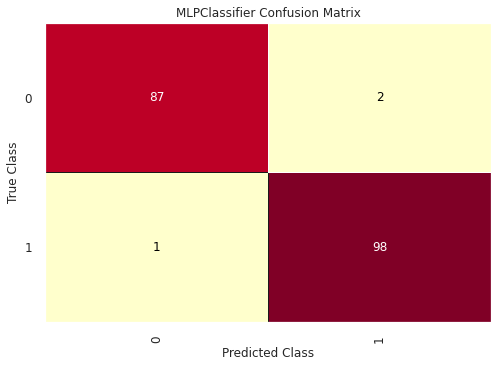

Classifier = AdaBoost, Score (test, accuracy) = 99.47,
F1 SCORE = 1.00,


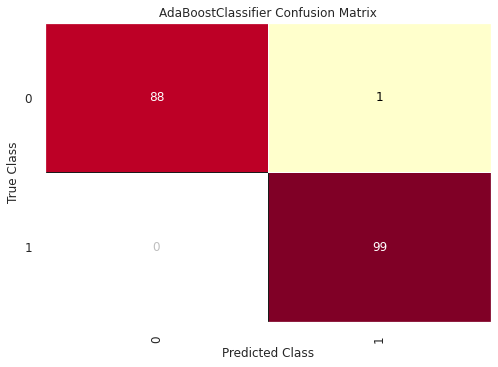

Classifier = Naive Bayes, Score (test, accuracy) = 72.34,
F1 SCORE = 0.67,


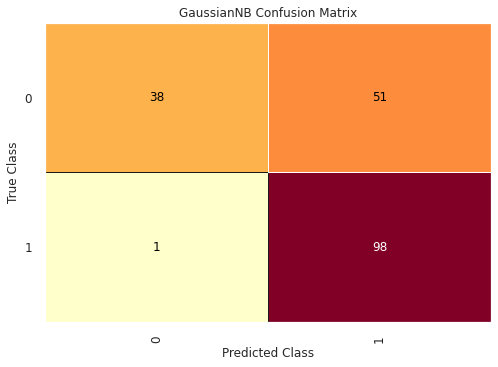

Classifier = QDA, Score (test, accuracy) = 63.30,
F1 SCORE = 0.51,


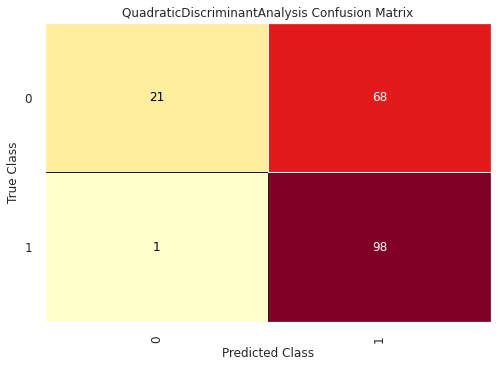

--------------------------------------------------------------------------------
Best --> Classifier = Decision Tree, Score (test, accuracy) = 99.47
--------------------------------------------------------------------------------
Classifier = Nearest Neighbors, Score (test, accuracy) = 95.74,
F1 SCORE = 0.98,


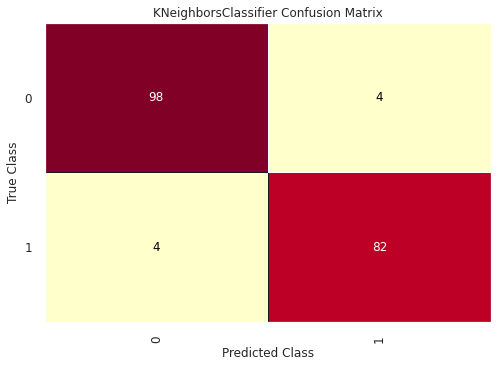

Classifier = Linear SVM, Score (test, accuracy) = 93.09,
F1 SCORE = 0.93,


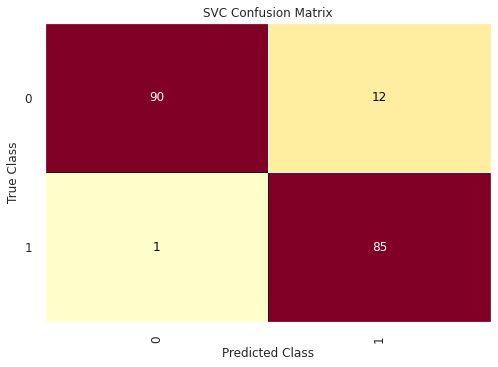

Classifier = RBF SVM, Score (test, accuracy) = 94.15,
F1 SCORE = 1.00,


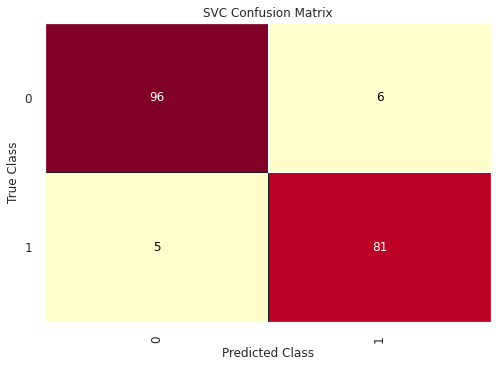

Classifier = Decision Tree, Score (test, accuracy) = 100.00,
F1 SCORE = 1.00,


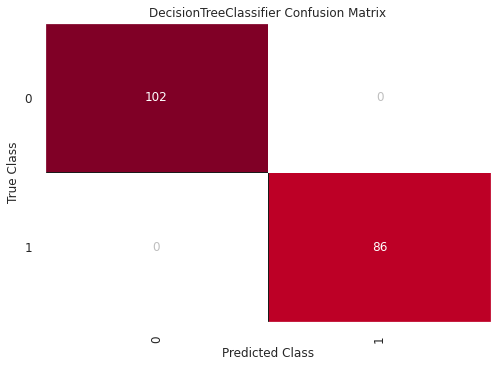

Classifier = Random Forest, Score (test, accuracy) = 100.00,
F1 SCORE = 1.00,


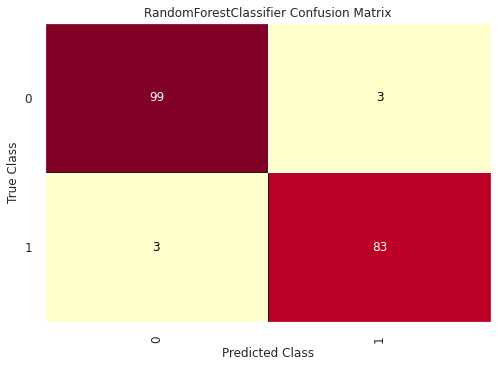

Classifier = Neural Net, Score (test, accuracy) = 98.40,
F1 SCORE = 0.99,


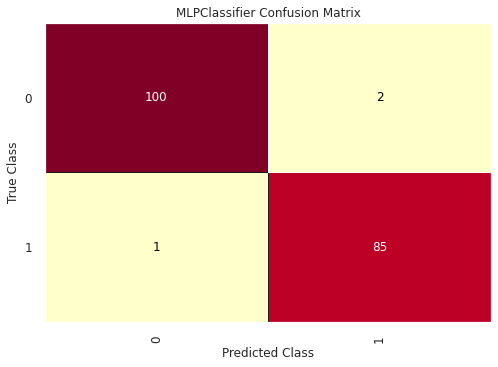

Classifier = AdaBoost, Score (test, accuracy) = 100.00,
F1 SCORE = 1.00,


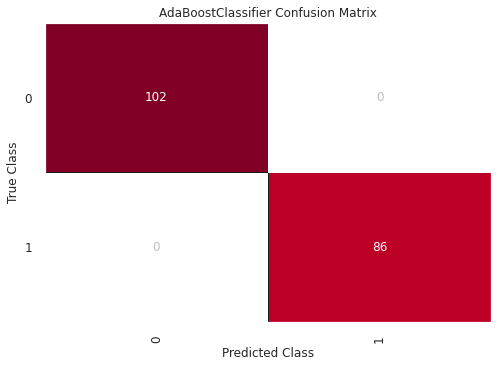

Classifier = Naive Bayes, Score (test, accuracy) = 66.49,
F1 SCORE = 0.64,


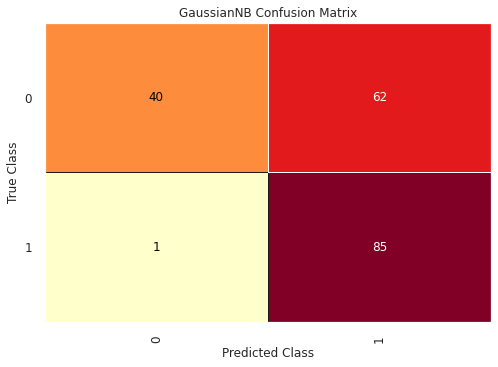

Classifier = QDA, Score (test, accuracy) = 68.62,
F1 SCORE = 0.68,


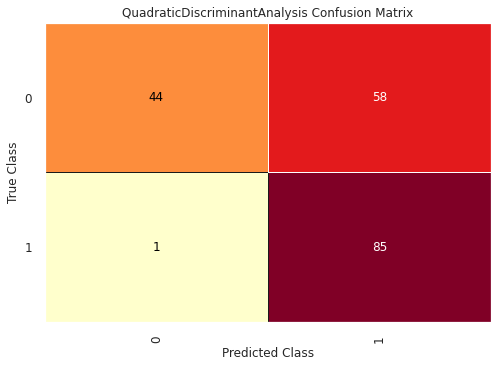

--------------------------------------------------------------------------------
Best --> Classifier = Decision Tree, Score (test, accuracy) = 100.00
--------------------------------------------------------------------------------


In [ ]:
df_ml = data[['Calories','Avg steps per km','VeryActiveDistance','TotalMinutes','In lockdown_Yes']].copy()
featureTransformation(df_ml);

df_ml = data[['Calories','Avg steps per km','VeryActiveDistance','TotalMinutes','In lockdown_Yes']].copy()
featureTransformation(df_ml);
 
df_ml = data[['TrackerDistance','LoggedActivitiesDistance','VeryActiveDistance','ModeratelyActiveDistance','LightActiveDistance','LightlyActiveMinutes','SedentaryMinutes','Calories','TotalMinutes','Active minutes','Avg steps per km','In lockdown_Yes']].copy()
featureTransformation(df_ml);
 
df_ml = data[['TrackerDistance','LoggedActivitiesDistance','VeryActiveDistance','SedentaryMinutes','Calories','TotalMinutes','Active minutes','Avg steps per km','In lockdown_Yes']].copy()
featureTransformation(df_ml);
 


Classifier = Nearest Neighbors, Score (test, accuracy) = 86.70,
F1 SCORE = 0.93,


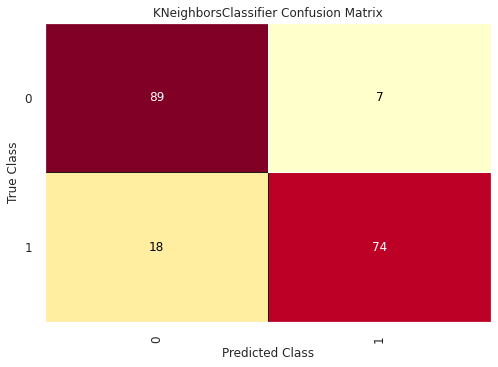

Classifier = Linear SVM, Score (test, accuracy) = 94.68,
F1 SCORE = 0.96,


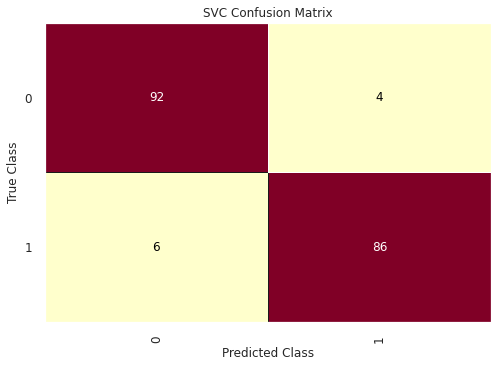

Classifier = RBF SVM, Score (test, accuracy) = 74.47,
F1 SCORE = 1.00,


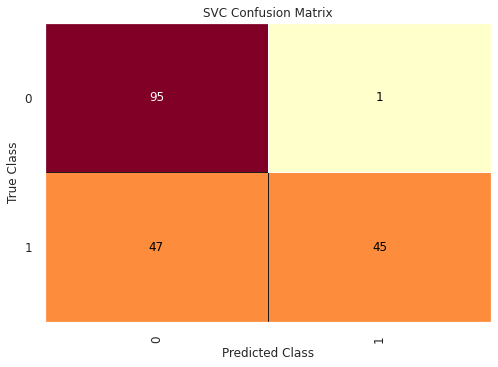

Classifier = Decision Tree, Score (test, accuracy) = 99.47,
F1 SCORE = 1.00,


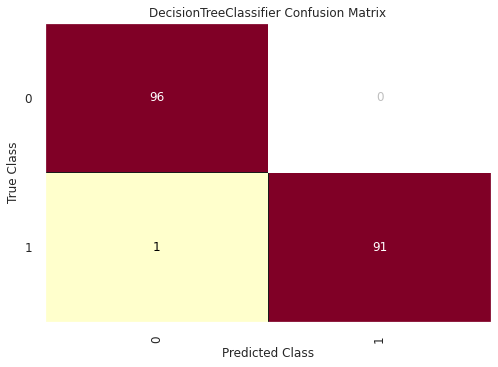

Classifier = Random Forest, Score (test, accuracy) = 92.55,
F1 SCORE = 0.94,


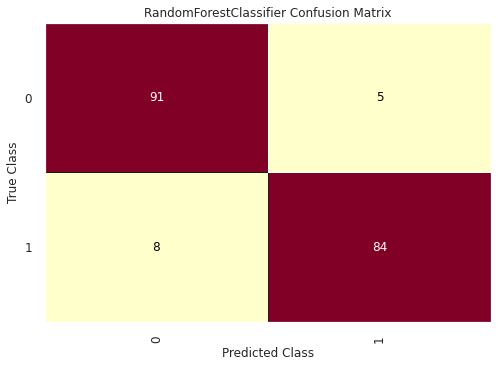

Classifier = Neural Net, Score (test, accuracy) = 97.34,
F1 SCORE = 0.99,


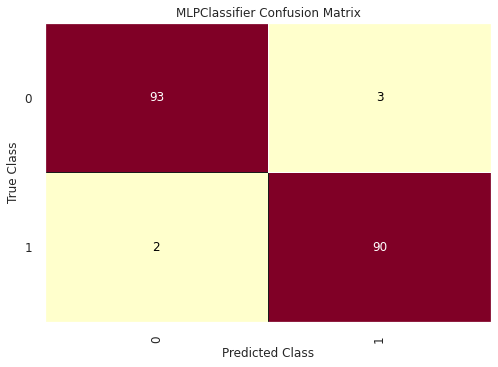

Classifier = AdaBoost, Score (test, accuracy) = 99.47,
F1 SCORE = 1.00,


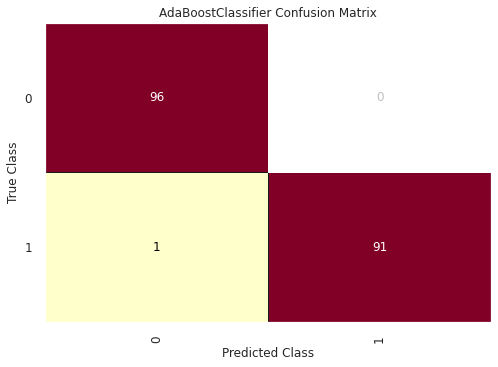

Classifier = Naive Bayes, Score (test, accuracy) = 68.09,
F1 SCORE = 0.66,


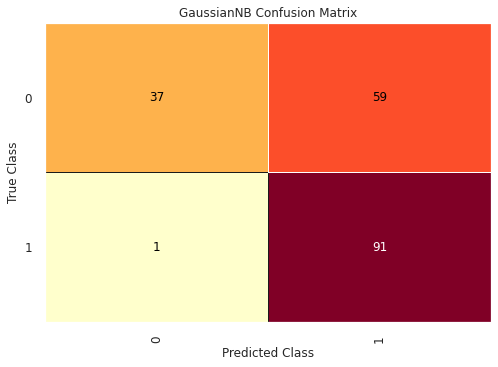

Classifier = QDA, Score (test, accuracy) = 61.70,
F1 SCORE = 0.61,


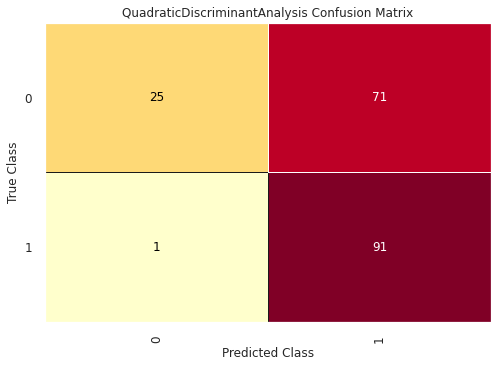

--------------------------------------------------------------------------------
Best --> Classifier = Decision Tree, Score (test, accuracy) = 99.47
--------------------------------------------------------------------------------


In [ ]:
featureTransformation(data)

*** Best accuracy score using Mueller Classifier are for the following columns Calories, Avg steps per km, VeryActiveDistance, TotalMinutes, In lockdown_Yes ***


In [ ]:
len(X_train),len(y_train)

(752, 752)

# Upsampling

In [ ]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

print(imblearn.__version__)

oversample = RandomOverSampler(sampling_strategy='minority')
X_train_os_res, y_train_os_res = oversample.fit_sample(X_train, y_train)
print(Counter(y_train_os_res))

0.4.3
Counter({1778.5087719298247: 14, 52.0: 14, 1637.7611940298507: 12, 1751.111111111111: 11, 1736.4259259259259: 11, 1834.7916666666667: 10, 1774.8333333333333: 9, 1748.9622641509434: 6, 2044.0: 4, 1922.0: 4, 1788.0: 3, 1985.0: 3, 2093.0: 3, 2095.0: 3, 1632.0: 3, 2067.0: 3, 1995.0: 3, 2066.0: 3, 2105.0: 3, 2194.0: 3, 2324.0: 3, 2225.0: 3, 1909.0: 2, 2124.0: 2, 1718.0: 2, 1722.0: 2, 2004.0: 2, 1431.0: 2, 1705.0: 2, 1776.0: 2, 2010.0: 2, 1725.0: 2, 1908.0: 2, 2098.0: 2, 1463.0: 2, 1880.0: 2, 1397.0: 2, 1529.0: 2, 1554.0: 2, 1882.0: 2, 1990.0: 2, 1604.0: 2, 1921.0: 2, 2116.0: 2, 1638.0: 2, 1763.0: 2, 1570.0: 2, 1667.0: 2, 2094.0: 2, 1370.0: 2, 1792.0: 2, 1970.0: 2, 1481.0: 2, 1827.0: 2, 1886.0: 2, 1946.0: 2, 2086.0: 2, 1916.0: 2, 1401.0: 2, 1655.0: 2, 1898.0: 2, 1976.0: 2, 2070.0: 2, 1593.0: 2, 1854.0: 2, 1972.0: 2, 1692.0: 2, 1780.0: 2, 1947.0: 2, 1740.0: 2, 1962.0: 2, 1878.0: 2, 2015.0: 2, 1742.0: 2, 1906.0: 2, 1698.0: 2, 1819.0: 2, 1821.0: 2, 1630.0: 2, 2220.0: 2, 2344.0: 2, 2560.0:

In [ ]:
len(X_train_os_res),len(y_train_os_res)

(765, 765)

# Downsampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train_os_res, y_train_os_res = oversample.fit_sample(X_train, y_train)
print(Counter(y_train_os_res))

Counter({1778.5087719298247: 14, 52.0: 14, 1637.7611940298507: 12, 1751.111111111111: 11, 1736.4259259259259: 11, 1834.7916666666667: 10, 1774.8333333333333: 9, 1748.9622641509434: 6, 2044.0: 4, 1922.0: 4, 1788.0: 3, 1985.0: 3, 2093.0: 3, 2095.0: 3, 1632.0: 3, 2067.0: 3, 1995.0: 3, 2066.0: 3, 2105.0: 3, 2194.0: 3, 2324.0: 3, 2225.0: 3, 1909.0: 2, 2124.0: 2, 1718.0: 2, 1722.0: 2, 2004.0: 2, 1431.0: 2, 1705.0: 2, 1776.0: 2, 2010.0: 2, 1725.0: 2, 1908.0: 2, 2098.0: 2, 1463.0: 2, 1880.0: 2, 1397.0: 2, 1529.0: 2, 1554.0: 2, 1882.0: 2, 1990.0: 2, 1604.0: 2, 1921.0: 2, 2116.0: 2, 1638.0: 2, 1763.0: 2, 1570.0: 2, 1667.0: 2, 2094.0: 2, 1370.0: 2, 1792.0: 2, 1970.0: 2, 1481.0: 2, 1827.0: 2, 1886.0: 2, 1946.0: 2, 2086.0: 2, 1916.0: 2, 1401.0: 2, 1655.0: 2, 1898.0: 2, 1976.0: 2, 2070.0: 2, 1593.0: 2, 1854.0: 2, 1972.0: 2, 1692.0: 2, 1780.0: 2, 1947.0: 2, 1740.0: 2, 1962.0: 2, 1878.0: 2, 2015.0: 2, 1742.0: 2, 1906.0: 2, 1698.0: 2, 1819.0: 2, 1821.0: 2, 1630.0: 2, 2220.0: 2, 2344.0: 2, 2560.0: 2, 23

# Confusion Matrix on Best Classifier

# Gini score

In [ ]:
!pip install scikit-optimize

Index(['Calories', 'Avg steps per km', 'VeryActiveDistance', 'TotalMinutes',
       'In lockdown_Yes'],
      dtype='object')
0.9914893617021276 OrderedDict([('max_depth', 44), ('n_estimators', 111)])
Index(['Calories', 'Avg steps per km', 'VeryActiveDistance', 'TotalMinutes',
       'In lockdown_Yes'],
      dtype='object')


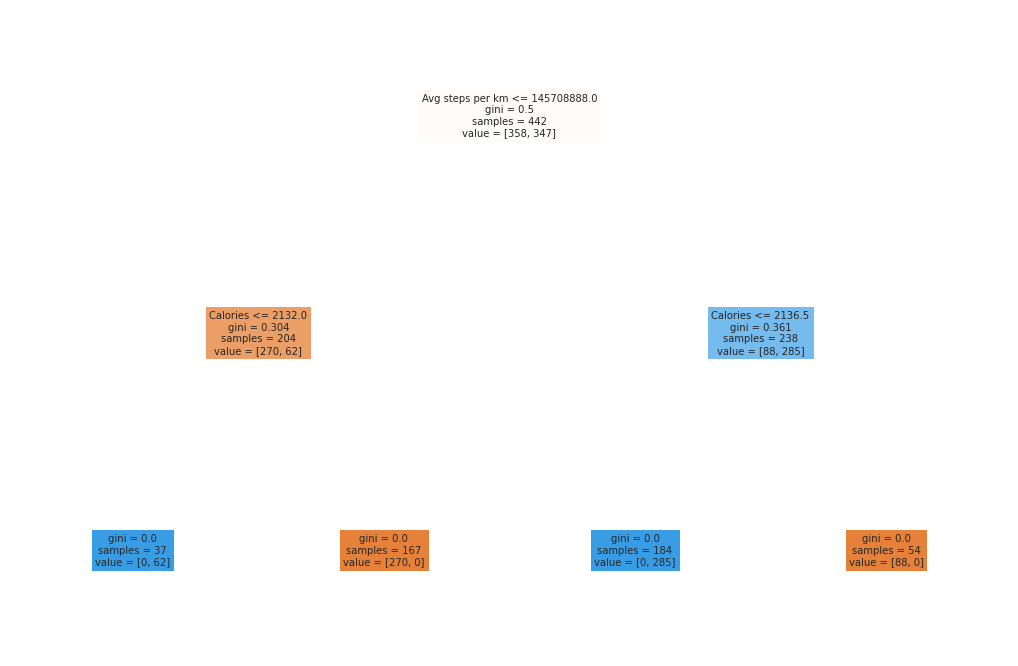

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn import svm
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn import tree

import sklearn.metrics as metrics
import skopt

df_ml = data[['Calories','Avg steps per km','VeryActiveDistance','TotalMinutes','In lockdown_Yes']].copy()
df_ml.drop(columns ='In lockdown_Yes')
fn=df_ml.columns
print(fn)
X = df_ml.drop('In lockdown_Yes', axis=1)
y = df_ml['In lockdown_Yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

clf = RandomForestClassifier(n_estimators=399, max_depth=27)  # hyperparameters optimised using BayesSearchCV
clf.fit(X_train, y_train)

X_train.head()
params = {'n_estimators': (5,400),
          'max_depth': (3, 50)}

optimiser = BayesSearchCV(clf, params, n_jobs=-1, n_iter=10)
opt = BayesSearchCV( svm.SVC(), { 'C': Real(1e-6, 1e+6, prior='log-uniform'), 'gamma': Real(1e-6, 1e+1, prior='log-uniform'), 'degree': Integer(1,8), 'kernel': Categorical(['linear', 'poly', 'rbf']), }, n_iter=32 )
#executes bayesian optimization
optimiser.fit(X_train, y_train)

print(optimiser.score(X_test, y_test), optimiser.best_params_)
clf.fit(X_train, y_train)
pred = clf.predict(X_train)
fn=df_ml.columns
print(fn)


fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize=(18, 12))
tree.plot_tree(clf.estimators_[0],
               feature_names = fn, 
               max_depth=5, fontsize=10,
               filled = True);
fig.savefig('clf_individualtree.png')

# Visualiazation (slider)

In [ ]:
pip install git+https://github.com/holoviz/hvplot.git

  Cloning https://github.com/holoviz/hvplot.git to /tmp/pip-req-build-0v_m2du6
  Running command git clone -q https://github.com/holoviz/hvplot.git /tmp/pip-req-build-0v_m2du6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
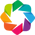

In [ ]:
import hvplot.pandas
import panel as pn
import holoviews as hv
hv.extension('bokeh')
# select_origin =pn.widgets.Select(options=['Yes','No'],name ='In lockdown_Yes')
select_cyl=pn.widgets.IntSlider(name='VeryActiveDistance Increment',start=1,end =10,step=1)
@pn.depends(select_cyl)
def exp_plot(select_cyl):
  return df_ml[(df_ml['VeryActiveDistance'] >= select_cyl)].sort_values(by='Calories').hvplot(x='Calories',y='VeryActiveDistance')
pn.Column(select_cyl,exp_plot).embed()


# Pickle and load the best classifier


## The Best Model

Please refer to this link for the file of Best Model: 

In [ ]:
import pickle
file = open('model', 'wb')
clf_best = RandomForestClassifier(max_depth=5)
clf_best.fit(X_train, y_train)
score = 100.0 * clf_best.score(X_test, y_test)
pickle.dump(clf_best, file)
file.close()

In [ ]:
file = open('model', 'rb')
best_clf = pickle.load(file)
y_pred = best_clf.predict(X_test)


# Summary
  * Collected the Data from Kaggle for FitBit.
  * Amalgamated the Data from other websites for in_lockdown and pre_lockdown.
  * Cleaned the data for null/nan, duplicates.
  * Visualize the data.
  * Prepared data again for second amalgamation.
  * Visualized the data again.
  * Dimensionality reduction via PCA.
  * Calculated the Feature importance.
  * Fractal Clustering for Latent Variables.
  * Find the Golden Cluster.
  * Training and Modelling the data with multiple regressors and calssifiers.
  * Performed Change in data distribution.  
  * Performed Upsampling and Downsampling.  
  * Identified the Gini Score F1 Score and R2 Score.  
  * Identified GradientBoostingRegressor model as the most accurate.  
  * Identified  NearestNeighbourClassifier model as the most accurate.  
  * Using hvplot library visualization of data distibution using slider.  
  * Pickle and load with best classifier.